#Đánh giá Hiệu Suất Kịch Bản no-shot prompt cho LLMs annotation 

2025-07-01 16:28:29,622 - INFO - 
========== Đánh giá Đồng thuận Nhãn Bloom và Ma trận nhầm lẫn ==========
2025-07-01 16:28:29,624 - INFO - Đang tải dữ liệu gắn nhãn của người từ: D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv
2025-07-01 16:28:29,632 - INFO - Đã tải 220 mục từ dữ liệu của người.
2025-07-01 16:28:29,633 - INFO - Đang tải dữ liệu gắn nhãn của máy từ: D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_no_test102.json
2025-07-01 16:28:29,637 - INFO - Đã tải 110 mục từ dữ liệu của máy.
2025-07-01 16:28:29,653 - INFO - Tìm thấy 110 mục chung để tính đồng thuận nhãn Bloom.
2025-07-01 16:28:29,656 - INFO - 
--- Ma trận nhầm lẫn cho Nhãn Bloom ---


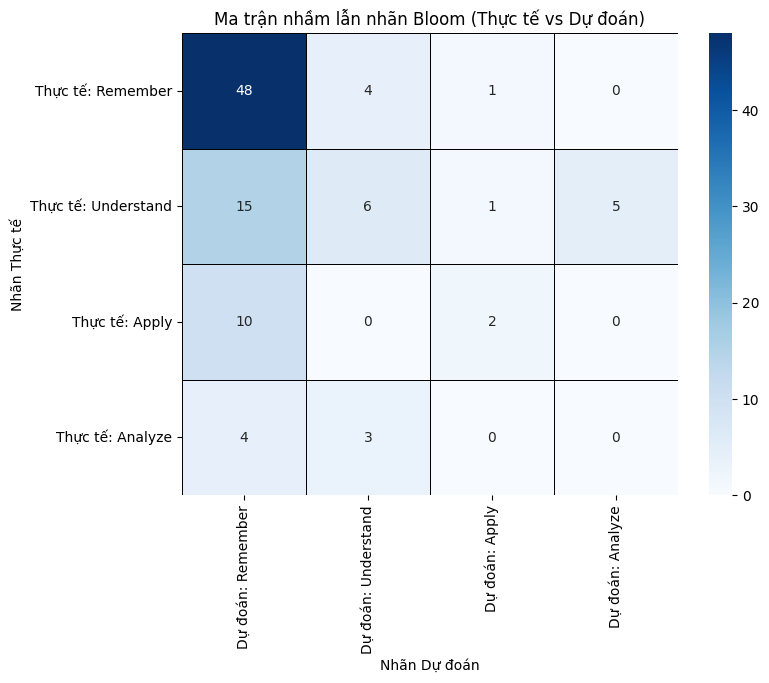

2025-07-01 16:28:29,783 - INFO - 
Độ chính xác (nhãn Bloom) trên 110 mục chung: 58.18%
2025-07-01 16:28:29,785 - INFO - Cohen's Kappa (nhãn Bloom) giữa Người và Máy: 0.3059
2025-07-01 16:28:29,786 - INFO - 
--- Báo cáo phân loại (Precision, Recall, F1-score theo từng nhãn) ---
2025-07-01 16:28:29,799 - INFO - 
F1-score tổng thể (weighted avg) cho Nhãn Bloom: 0.5051


              precision    recall  f1-score   support

    Remember       0.62      0.86      0.72        56
  Understand       0.46      0.22      0.30        27
       Apply       0.50      0.17      0.25        12
     Analyze       0.00      0.00      0.00         7

   micro avg       0.57      0.55      0.56       102
   macro avg       0.40      0.31      0.32       102
weighted avg       0.52      0.55      0.51       102


Kết quả đánh giá nhãn Bloom:
  Độ chính xác (Nhãn Bloom): 58.18%
  Cohen's Kappa (Nhãn Bloom): 0.3059
  F1-score tổng thể (Nhãn Bloom): 0.5051


In [ ]:
import pandas as pd
import json
import logging
import re
from collections import Counter
import os
from typing import Optional, Dict, Any, List
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, classification_report, f1_score
import numpy as np
import seaborn as sns # Import thư viện seaborn
import matplotlib.pyplot as plt # Import thư viện matplotlib để hiển thị biểu đồ

# Cấu hình logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def normalize_answer(s: str) -> str:
    """
    Chuẩn hóa câu trả lời: chuyển về chữ thường, loại bỏ dấu câu, loại bỏ khoảng trắng thừa.
    Ví dụ: "Xin chào, thế giới!" -> "xin chao the gioi"
    """
    def remove_punc(text):
        # Giữ lại các ký tự chữ cái, số và khoảng trắng. Loại bỏ tất cả các ký tự khác.
        return re.sub(r'[^\w\s]', '', text)

    def lower_and_strip(text):
        return text.lower().strip()

    s = lower_and_strip(s)
    s = remove_punc(s)
    # Thay thế nhiều khoảng trắng thành một khoảng trắng duy nhất
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def compute_f1_score(prediction: str, ground_truth: str) -> float:
    """
    Tính F1 score dựa trên sự trùng lặp token giữa câu trả lời dự đoán và câu trả lời thật.
    Đây là cách tính F1 score thường dùng trong các bài toán Question Answering (ví dụ SQuAD).
    """
    # Chuẩn hóa và tách token
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()

    # Xử lý trường hợp đặc biệt: cả hai chuỗi đều rỗng
    if not prediction_tokens and not ground_truth_tokens:
        return 1.0 # Coi như trùng khớp hoàn hảo nếu cả hai đều không có nội dung
    # Xử lý trường hợp một trong hai chuỗi rỗng
    if not prediction_tokens or not ground_truth_tokens:
        return 0.0 # Không có sự trùng khớp nếu một bên rỗng

    # Đếm số lần xuất hiện của mỗi token trong cả hai chuỗi
    # Counter giúp xử lý các từ lặp lại (ví dụ: "a a b" và "a b b" -> common "a b")
    common_tokens = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common_tokens.values())

    if num_same == 0:
        return 0.0

    # Tính Precision (Độ chính xác) và Recall (Độ phủ)
    precision = num_same / len(prediction_tokens)
    recall = num_same / len(ground_truth_tokens)
    
    # Tránh chia cho 0 nếu precision và recall đều bằng 0
    if precision + recall == 0:
        return 0.0
    
    # Tính F1 score
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def calculate_average_f1_and_accuracy(ground_truth_path: str, prediction_path: str) -> Optional[Dict[str, float]]:
    """
    Tải dữ liệu từ hai file (CSV/JSON), tìm các câu hỏi chung, và tính F1 score trung bình
    và Accuracy (tỷ lệ các câu trả lời khớp hoàn hảo).

    Args:
        ground_truth_path (str): Đường dẫn đến file chứa dữ liệu "thật" (ground truth).
                                 Hỗ trợ CSV.
        prediction_path (str): Đường dẫn đến file chứa dữ liệu "dự đoán" (prediction).
                               Hỗ trợ CSV hoặc JSON.

    Returns:
        Optional[Dict[str, float]]: Dictionary chứa F1 score trung bình và Accuracy,
                                    hoặc None nếu có lỗi.
    """
    logger.info(f"Đang tải dữ liệu ground truth từ: {ground_truth_path}")
    try:
        gt_df = pd.read_csv(ground_truth_path, encoding='utf-8')
        gt_df_indexed = gt_df.set_index('question') 
        logger.info(f"Đã tải {len(gt_df_indexed)} cặp Q&A từ ground truth.")
    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file ground truth tại '{ground_truth_path}'.")
        return None
    except KeyError:
        logger.error(f"Lỗi: File ground truth '{ground_truth_path}' phải có cột 'question' và 'answer'.")
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file ground truth '{ground_truth_path}': {e}", exc_info=True)
        return None

    logger.info(f"Đang tải dữ liệu dự đoán từ: {prediction_path}")
    try:
        if prediction_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(prediction_path, encoding='utf-8')
        elif prediction_path.lower().endswith('.json'):
            with open(prediction_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"Lỗi: Định dạng file dự đoán '{prediction_path}' không được hỗ trợ. Chỉ chấp nhận .csv hoặc .json.")
            return None
            
        pred_df_indexed = pred_df.set_index('question')
        logger.info(f"Đã tải {len(pred_df_indexed)} cặp Q&A từ dữ liệu dự đoán.")

    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dự đoán tại '{prediction_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"Lỗi: File dự đoán '{prediction_path}' phải có cột 'question' và 'answer' và định dạng hợp lệ: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dự đoán '{prediction_path}': {e}", exc_info=True)
        return None

    f1_scores = []
    perfect_matches = 0
    processed_questions_count = 0

    for q_gt in gt_df_indexed.index:
        if q_gt in pred_df_indexed.index:
            ground_truth_answer = str(gt_df_indexed.loc[q_gt]['answer'])
            prediction_answer = str(pred_df_indexed.loc[q_gt]['answer'])
            
            f1 = compute_f1_score(prediction_answer, ground_truth_answer)
            f1_scores.append(f1)
            processed_questions_count += 1
            
            if f1 == 1.0:
                perfect_matches += 1

    if not f1_scores:
        logger.warning("Không tìm thấy câu hỏi chung nào giữa hai tập dữ liệu. Không thể tính F1 score hoặc Accuracy.")
        return {'average_f1': 0.0, 'accuracy': 0.0}

    logger.info(f"Tìm thấy {processed_questions_count} câu hỏi chung để tính F1 score và Accuracy.")

    average_f1 = sum(f1_scores) / len(f1_scores)
    accuracy = (perfect_matches / processed_questions_count) * 100 if processed_questions_count > 0 else 0.0
    
    logger.info(f"F1 Score trung bình trên {processed_questions_count} câu hỏi chung: {average_f1:.4f}")
    logger.info(f"Accuracy (khớp hoàn hảo) trên {processed_questions_count} câu hỏi chung: {accuracy:.2f}%")

    return {'average_f1': average_f1, 'accuracy': accuracy}

def extract_bloom_level(label_string: str) -> str:
    """
    Trích xuất cấp độ Bloom chính từ chuỗi nhãn có thể chứa mô tả.
    Ví dụ: "Remember (Ghi nhớ): Nhớ lại thông tin cơ bản..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip() # Xử lý trường hợp không phải chuỗi (ví dụ NaN)

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip() # Trả về nguyên bản nếu không khớp (hoặc rỗng nếu không có gì)


def evaluate_bloom_labels(human_labeled_path: str, llm_labeled_path: str,
                          id_column: str = 'question', 
                          human_bloom_label_column: str = 'bloom', # Tên cột nhãn Bloom cho file của người
                          llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]: # Tên cột nhãn Bloom cho file của máy
    """
    Tải dữ liệu đã gắn nhãn của người và máy, sau đó so sánh các nhãn Bloom
    và in ra Confusion Matrix, Accuracy, và Cohen's Kappa.

    Args:
        human_labeled_path (str): Đường dẫn đến file chứa dữ liệu do người gắn nhãn.
                                   Hỗ trợ CSV.
        llm_labeled_path (str): Đường dẫn đến file chứa dữ liệu do LLM gắn nhãn.
                                  Hỗ trợ CSV hoặc JSON.
        id_column (str): Tên cột chứa ID duy nhất của mỗi mục (ví dụ: 'question').
                         Cột này sẽ được dùng để khớp các mục giữa hai file.
        human_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của người.
        llm_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của máy.

    Returns:
        Optional[Dict[str, Any]]: Một dictionary chứa các metric và confusion matrix,
                                  hoặc None nếu có lỗi.
    """
    logger.info(f"Đang tải dữ liệu gắn nhãn của người từ: {human_labeled_path}")
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
        logger.info(f"Đã tải {len(human_df_indexed)} mục từ dữ liệu của người.")
    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của người tại '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"Lỗi: File dữ liệu của người phải có cột '{id_column}' và '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của người '{human_labeled_path}': {e}", exc_info=True)
        return None

    logger.info(f"Đang tải dữ liệu gắn nhãn của máy từ: {llm_labeled_path}")
    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"Lỗi: Định dạng file dữ liệu của máy '{llm_labeled_path}' không được hỗ trợ. Chỉ chấp nhận .csv hoặc .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)
        logger.info(f"Đã tải {len(llm_df_indexed)} mục từ dữ liệu của máy.")

    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của máy tại '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"Lỗi: File dữ liệu của máy '{llm_labeled_path}' phải có cột '{id_column}' và '{llm_bloom_label_column}' và định dạng hợp lệ: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của máy '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    # Lặp qua các mục trong dữ liệu của người và tìm các mục chung với dữ liệu của máy
    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                # Lấy nhãn của người (từ CSV, cột 'bloom')
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw) # Đảm bảo chuẩn hóa nếu cần

                # Lấy nhãn của máy (từ JSON, cột 'bloom_label')
                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw) # Trích xuất chỉ cấp độ Bloom

                # Bỏ qua các nhãn rỗng hoặc không hợp lệ sau khi trích xuất
                if not human_label or not llm_label:
                    logger.warning(f"Mục '{item_id}': Nhãn Bloom rỗng hoặc không hợp lệ sau khi trích xuất. Bỏ qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"Mục '{item_id}' không có cột nhãn Bloom cần thiết ({e}). Bỏ qua.")
                continue
            except Exception as e:
                logger.warning(f"Lỗi xử lý mục '{item_id}': {e}. Bỏ qua.")
                continue

    if common_items_count == 0:
        logger.warning("Không tìm thấy mục chung nào giữa hai tập dữ liệu hoặc không có nhãn. Không thể tính các metric đồng thuận nhãn Bloom.")
        return None

    logger.info(f"Tìm thấy {common_items_count} mục chung để tính đồng thuận nhãn Bloom.")

    # Định nghĩa các nhãn Bloom theo thứ tự mong muốn
    # Đảm bảo các nhãn này khớp chính xác với các nhãn trong dữ liệu của bạn (ví dụ: viết hoa/thường)
    # Nếu có các nhãn khác ngoài 4 nhãn này, chúng sẽ không được bao gồm trong ma trận nếu bạn chỉ định labels
    # Nếu bạn muốn tự động phát hiện tất cả các nhãn, hãy dùng:
    # all_labels = sorted(list(set(true_labels + predicted_labels)))
    # Tuy nhiên, việc định nghĩa rõ ràng giúp đảm bảo thứ tự và bao gồm các nhãn có thể không xuất hiện trong tập con dữ liệu này.
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze']

    # 1. Tính Confusion Matrix
    # cm[i, j] là số lượng mẫu thực tế thuộc lớp i được dự đoán là lớp j
    cm = confusion_matrix(true_labels, predicted_labels, labels=bloom_categories)
    cm_df = pd.DataFrame(cm, index=[f'Thực tế: {l}' for l in bloom_categories], columns=[f'Dự đoán: {l}' for l in bloom_categories])
    
    logger.info("\n--- Ma trận nhầm lẫn cho Nhãn Bloom ---")
    # Thay vì print(cm_df), chúng ta sẽ vẽ heatmap
    plt.figure(figsize=(8, 6)) # Kích thước biểu đồ
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, linecolor='black')
    plt.title('Ma trận nhầm lẫn nhãn Bloom (Thực tế vs Dự đoán)')
    plt.xlabel('Nhãn Dự đoán')
    plt.ylabel('Nhãn Thực tế')
    plt.show() # Hiển thị biểu đồ

    # 2. Tính Accuracy
    acc = accuracy_score(true_labels, predicted_labels) * 100
    logger.info(f"\nĐộ chính xác (nhãn Bloom) trên {common_items_count} mục chung: {acc:.2f}%")

    # 3. Tính Cohen's Kappa (thích hợp cho 2 người đánh giá)
    kappa = cohen_kappa_score(true_labels, predicted_labels)
    logger.info(f"Cohen's Kappa (nhãn Bloom) giữa Người và Máy: {kappa:.4f}")

    # 4. In báo cáo phân loại chi tiết hơn (Precision, Recall, F1-score cho từng lớp)
    logger.info("\n--- Báo cáo phân loại (Precision, Recall, F1-score theo từng nhãn) ---")
    # zero_division=0 để tránh cảnh báo/lỗi khi một lớp không có mẫu nào
    report_dict = classification_report(true_labels, predicted_labels, labels=bloom_categories, output_dict=True, zero_division=0)
    print(classification_report(true_labels, predicted_labels, labels=bloom_categories, zero_division=0)) # In báo cáo dạng bảng

    # Lấy F1-score tổng thể (weighted average)
    overall_f1_bloom = report_dict['weighted avg']['f1-score']
    logger.info(f"\nF1-score tổng thể (weighted avg) cho Nhãn Bloom: {overall_f1_bloom:.4f}")

    return {
        'confusion_matrix': cm_df,
        'accuracy_bloom': acc,
        'cohen_kappa': kappa,
        'f1_score_bloom': overall_f1_bloom # Thêm F1-score tổng thể vào kết quả trả về
    }

# --- Chạy chương trình ---
if __name__ == "__main__":
    # --- Đánh giá nhãn Bloom và Confusion Matrix ---
    # Các file này cũng chứa cột 'bloom_label' hoặc 'bloom'
    human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" # Đường dẫn đến file nhãn Bloom của người
    llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_no_test102.json" # Đường dẫn đến file nhãn Bloom của máy

    # Đảm bảo các tên cột này khớp với tên cột trong file của bạn
    ITEM_ID_COLUMN = 'question' # Cột ID để khớp các mục
    HUMAN_BLOOM_LABEL_COLUMN = 'bloom' # Tên cột nhãn Bloom trong file CSV của người
    LLM_BLOOM_LABEL_COLUMN = 'bloom_label' # Tên cột nhãn Bloom trong file JSON của máy

    logger.info("\n========== Đánh giá Đồng thuận Nhãn Bloom và Ma trận nhầm lẫn ==========")
    bloom_results = evaluate_bloom_labels(
        human_labeled_path=human_bloom_path,
        llm_labeled_path=llm_bloom_path,
        id_column=ITEM_ID_COLUMN,
        human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
        llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
    )

    if bloom_results:
        print(f"\nKết quả đánh giá nhãn Bloom:")
        print(f"  Độ chính xác (Nhãn Bloom): {bloom_results['accuracy_bloom']:.2f}%")
        print(f"  Cohen's Kappa (Nhãn Bloom): {bloom_results['cohen_kappa']:.4f}")
        print(f"  F1-score tổng thể (Nhãn Bloom): {bloom_results['f1_score_bloom']:.4f}")
        # Ma trận nhầm lẫn và báo cáo phân loại đã được in trực tiếp trong hàm


#Đánh giá Hiệu Suất Kịch Bản few-shot prompt cho LLMs annotation 

2025-07-01 16:32:09,806 - INFO - 
========== Đánh giá Đồng thuận Nhãn Bloom và Ma trận nhầm lẫn cho LLM Few-Shot ==========
2025-07-01 16:32:09,807 - INFO - Đang tải dữ liệu gắn nhãn của người từ: D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv
2025-07-01 16:32:09,812 - INFO - Đã tải 220 mục từ dữ liệu của người.
2025-07-01 16:32:09,813 - INFO - Đang tải dữ liệu gắn nhãn của máy từ: D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json
2025-07-01 16:32:09,816 - INFO - Đã tải 110 mục từ dữ liệu của máy.
2025-07-01 16:32:09,832 - INFO - Tìm thấy 110 mục chung để tính đồng thuận nhãn Bloom.
2025-07-01 16:32:09,834 - INFO - 
--- Ma trận nhầm lẫn cho Nhãn Bloom ---


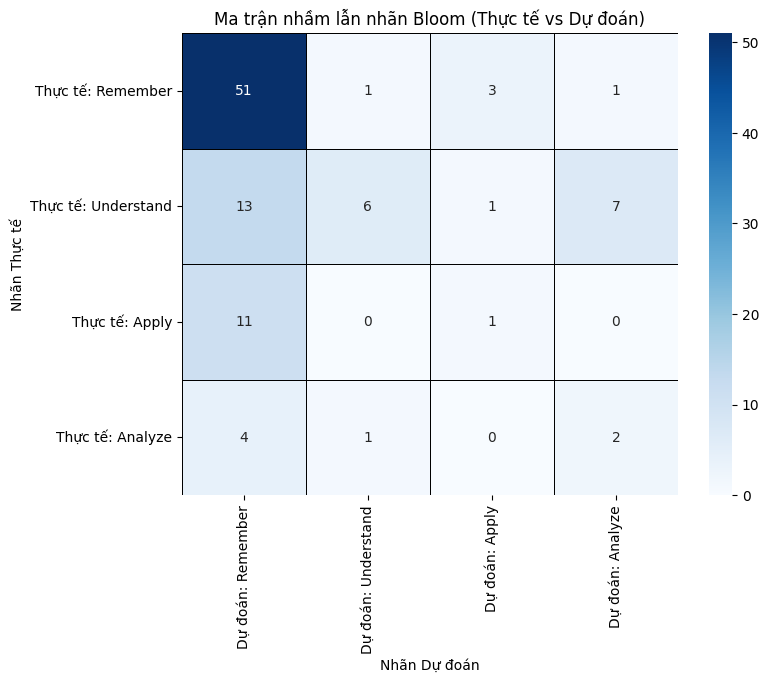

2025-07-01 16:32:09,975 - INFO - 
Độ chính xác (nhãn Bloom) trên 110 mục chung: 61.82%
2025-07-01 16:32:09,977 - INFO - Cohen's Kappa (nhãn Bloom) giữa Người và Máy: 0.3642
2025-07-01 16:32:09,978 - INFO - 
--- Báo cáo phân loại (Precision, Recall, F1-score theo từng nhãn) ---
2025-07-01 16:32:09,989 - INFO - 
F1-score tổng thể (weighted avg) cho Nhãn Bloom: 0.5356


              precision    recall  f1-score   support

    Remember       0.65      0.91      0.76        56
  Understand       0.75      0.22      0.34        27
       Apply       0.20      0.08      0.12        12
     Analyze       0.20      0.29      0.24         7

   micro avg       0.59      0.59      0.59       102
   macro avg       0.45      0.38      0.36       102
weighted avg       0.59      0.59      0.54       102


Kết quả đánh giá nhãn Bloom (LLM Few-Shot):
  Độ chính xác (Nhãn Bloom): 61.82%
  Cohen's Kappa (Nhãn Bloom): 0.3642
  F1-score tổng thể (Nhãn Bloom): 0.5356


In [26]:
import pandas as pd
import json
import logging
import re
from collections import Counter
import os
from typing import Optional, Dict, Any, List
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, classification_report, f1_score
import numpy as np
import seaborn as sns # Import thư viện seaborn
import matplotlib.pyplot as plt # Import thư viện matplotlib để hiển thị biểu đồ

# Cấu hình logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def normalize_answer(s: str) -> str:
    """
    Chuẩn hóa câu trả lời: chuyển về chữ thường, loại bỏ dấu câu, loại bỏ khoảng trắng thừa.
    Ví dụ: "Xin chào, thế giới!" -> "xin chao the gioi"
    """
    def remove_punc(text):
        # Giữ lại các ký tự chữ cái, số và khoảng trắng. Loại bỏ tất cả các ký tự khác.
        return re.sub(r'[^\w\s]', '', text)

    def lower_and_strip(text):
        return text.lower().strip()

    s = lower_and_strip(s)
    s = remove_punc(s)
    # Thay thế nhiều khoảng trắng thành một khoảng trắng duy nhất
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def compute_f1_score(prediction: str, ground_truth: str) -> float:
    """
    Tính F1 score dựa trên sự trùng lặp token giữa câu trả lời dự đoán và câu trả lời thật.
    Đây là cách tính F1 score thường dùng trong các bài toán Question Answering (ví dụ SQuAD).
    """
    # Chuẩn hóa và tách token
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()

    # Xử lý trường hợp đặc biệt: cả hai chuỗi đều rỗng
    if not prediction_tokens and not ground_truth_tokens:
        return 1.0 # Coi như trùng khớp hoàn hảo nếu cả hai đều không có nội dung
    # Xử lý trường hợp một trong hai chuỗi rỗng
    if not prediction_tokens or not ground_truth_tokens:
        return 0.0 # Không có sự trùng khớp nếu một bên rỗng

    # Đếm số lần xuất hiện của mỗi token trong cả hai chuỗi
    # Counter giúp xử lý các từ lặp lại (ví dụ: "a a b" và "a b b" -> common "a b")
    common_tokens = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common_tokens.values())

    if num_same == 0:
        return 0.0

    # Tính Precision (Độ chính xác) và Recall (Độ phủ)
    precision = num_same / len(prediction_tokens)
    recall = num_same / len(ground_truth_tokens)
    
    # Tránh chia cho 0 nếu precision và recall đều bằng 0
    if precision + recall == 0:
        return 0.0
    
    # Tính F1 score
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def extract_bloom_level(label_string: str) -> str:
    """
    Trích xuất cấp độ Bloom chính từ chuỗi nhãn có thể chứa mô tả.
    Ví dụ: "Remember (Ghi nhớ): Nhớ lại thông tin cơ bản..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip() # Xử lý trường hợp không phải chuỗi (ví dụ NaN)

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip() # Trả về nguyên bản nếu không khớp (hoặc rỗng nếu không có gì)


def evaluate_bloom_labels(human_labeled_path: str, llm_labeled_path: str,
                          id_column: str = 'question', 
                          human_bloom_label_column: str = 'bloom', # Tên cột nhãn Bloom cho file của người
                          llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]: # Tên cột nhãn Bloom cho file của máy
    """
    Tải dữ liệu đã gắn nhãn của người và máy, sau đó so sánh các nhãn Bloom
    và in ra Confusion Matrix, Accuracy, và Cohen's Kappa.

    Args:
        human_labeled_path (str): Đường dẫn đến file chứa dữ liệu do người gắn nhãn.
                                   Hỗ trợ CSV.
        llm_labeled_path (str): Đường dẫn đến file chứa dữ liệu do LLM gắn nhãn.
                                  Hỗ trợ CSV hoặc JSON.
        id_column (str): Tên cột chứa ID duy nhất của mỗi mục (ví dụ: 'question').
                         Cột này sẽ được dùng để khớp các mục giữa hai file.
        human_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của người.
        llm_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của máy.

    Returns:
        Optional[Dict[str, Any]]: Một dictionary chứa các metric và confusion matrix,
                                  hoặc None nếu có lỗi.
    """
    logger.info(f"Đang tải dữ liệu gắn nhãn của người từ: {human_labeled_path}")
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
        logger.info(f"Đã tải {len(human_df_indexed)} mục từ dữ liệu của người.")
    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của người tại '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"Lỗi: File dữ liệu của người phải có cột '{id_column}' và '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của người '{human_labeled_path}': {e}", exc_info=True)
        return None

    logger.info(f"Đang tải dữ liệu gắn nhãn của máy từ: {llm_labeled_path}")
    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"Lỗi: Định dạng file dữ liệu của máy '{llm_labeled_path}' không được hỗ trợ. Chỉ chấp nhận .csv hoặc .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)
        logger.info(f"Đã tải {len(llm_df_indexed)} mục từ dữ liệu của máy.")

    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của máy tại '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"Lỗi: File dữ liệu của máy '{llm_labeled_path}' phải có cột '{id_column}' và '{llm_bloom_label_column}' và định dạng hợp lệ: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của máy '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    # Lặp qua các mục trong dữ liệu của người và tìm các mục chung với dữ liệu của máy
    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                # Lấy nhãn của người (từ CSV, cột 'bloom')
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw) # Đảm bảo chuẩn hóa nếu cần

                # Lấy nhãn của máy (từ JSON, cột 'bloom_label')
                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw) # Trích xuất chỉ cấp độ Bloom

                # Bỏ qua các nhãn rỗng hoặc không hợp lệ sau khi trích xuất
                if not human_label or not llm_label:
                    logger.warning(f"Mục '{item_id}': Nhãn Bloom rỗng hoặc không hợp lệ sau khi trích xuất. Bỏ qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"Mục '{item_id}' không có cột nhãn Bloom cần thiết ({e}). Bỏ qua.")
                continue
            except Exception as e:
                logger.warning(f"Lỗi xử lý mục '{item_id}': {e}. Bỏ qua.")
                continue

    if common_items_count == 0:
        logger.warning("Không tìm thấy mục chung nào giữa hai tập dữ liệu hoặc không có nhãn. Không thể tính các metric đồng thuận nhãn Bloom.")
        return None

    logger.info(f"Tìm thấy {common_items_count} mục chung để tính đồng thuận nhãn Bloom.")

    # Định nghĩa các nhãn Bloom theo thứ tự mong muốn
    # Đảm bảo các nhãn này khớp chính xác với các nhãn trong dữ liệu của bạn (ví dụ: viết hoa/thường)
    # Nếu có các nhãn khác ngoài 4 nhãn này, chúng sẽ không được bao gồm trong ma trận nếu bạn chỉ định labels
    # Nếu bạn muốn tự động phát hiện tất cả các nhãn, hãy dùng:
    # all_labels = sorted(list(set(true_labels + predicted_labels)))
    # Tuy nhiên, việc định nghĩa rõ ràng giúp đảm bảo thứ tự và bao gồm các nhãn có thể không xuất hiện trong tập con dữ liệu này.
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze']

    # 1. Tính Confusion Matrix
    # cm[i, j] là số lượng mẫu thực tế thuộc lớp i được dự đoán là lớp j
    cm = confusion_matrix(true_labels, predicted_labels, labels=bloom_categories)
    cm_df = pd.DataFrame(cm, index=[f'Thực tế: {l}' for l in bloom_categories], columns=[f'Dự đoán: {l}' for l in bloom_categories])
    
    logger.info("\n--- Ma trận nhầm lẫn cho Nhãn Bloom ---")
    # Thay vì print(cm_df), chúng ta sẽ vẽ heatmap
    plt.figure(figsize=(8, 6)) # Kích thước biểu đồ
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, linecolor='black')
    plt.title('Ma trận nhầm lẫn nhãn Bloom (Thực tế vs Dự đoán)')
    plt.xlabel('Nhãn Dự đoán')
    plt.ylabel('Nhãn Thực tế')
    plt.show() # Hiển thị biểu đồ

    # 2. Tính Accuracy
    acc = accuracy_score(true_labels, predicted_labels) * 100
    logger.info(f"\nĐộ chính xác (nhãn Bloom) trên {common_items_count} mục chung: {acc:.2f}%")

    # 3. Tính Cohen's Kappa (thích hợp cho 2 người đánh giá)
    kappa = cohen_kappa_score(true_labels, predicted_labels)
    logger.info(f"Cohen's Kappa (nhãn Bloom) giữa Người và Máy: {kappa:.4f}")

    # 4. In báo cáo phân loại chi tiết hơn (Precision, Recall, F1-score cho từng lớp)
    logger.info("\n--- Báo cáo phân loại (Precision, Recall, F1-score theo từng nhãn) ---")
    # zero_division=0 để tránh cảnh báo/lỗi khi một lớp không có mẫu nào
    report_dict = classification_report(true_labels, predicted_labels, labels=bloom_categories, output_dict=True, zero_division=0)
    print(classification_report(true_labels, predicted_labels, labels=bloom_categories, zero_division=0)) # In báo cáo dạng bảng

    # Lấy F1-score tổng thể (weighted average)
    overall_f1_bloom = report_dict['weighted avg']['f1-score']
    logger.info(f"\nF1-score tổng thể (weighted avg) cho Nhãn Bloom: {overall_f1_bloom:.4f}")

    return {
        'confusion_matrix': cm_df,
        'accuracy_bloom': acc,
        'cohen_kappa': kappa,
        'f1_score_bloom': overall_f1_bloom # Thêm F1-score tổng thể vào kết quả trả về
    }

# --- Chạy chương trình ---
if __name__ == "__main__":
    # --- Đánh giá nhãn Bloom và Confusion Matrix cho LLM Few-Shot ---
    # Đường dẫn đến file nhãn Bloom của người (ground truth)
    human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
    # Đường dẫn đến file nhãn Bloom của LLM Few-Shot
    few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

    # Đảm bảo các tên cột này khớp với tên cột trong file của bạn
    ITEM_ID_COLUMN = 'question' # Cột ID để khớp các mục
    HUMAN_BLOOM_LABEL_COLUMN = 'bloom' # Tên cột nhãn Bloom trong file CSV của người
    LLM_BLOOM_LABEL_COLUMN = 'bloom_label' # Tên cột nhãn Bloom trong file JSON của máy (cả few-shot và zero-shot)

    logger.info("\n========== Đánh giá Đồng thuận Nhãn Bloom và Ma trận nhầm lẫn cho LLM Few-Shot ==========")
    bloom_results_few_shot = evaluate_bloom_labels(
        human_labeled_path=human_bloom_path,
        llm_labeled_path=few_shot_llm_bloom_path,
        id_column=ITEM_ID_COLUMN,
        human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
        llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
    )

    if bloom_results_few_shot:
        print(f"\nKết quả đánh giá nhãn Bloom (LLM Few-Shot):")
        print(f"  Độ chính xác (Nhãn Bloom): {bloom_results_few_shot['accuracy_bloom']:.2f}%")
        print(f"  Cohen's Kappa (Nhãn Bloom): {bloom_results_few_shot['cohen_kappa']:.4f}")
        print(f"  F1-score tổng thể (Nhãn Bloom): {bloom_results_few_shot['f1_score_bloom']:.4f}")
        # Ma trận nhầm lẫn và báo cáo phân loại đã được in trực tiếp trong hàm


In [36]:
import pandas as pd
import json
import logging
import re
from collections import Counter
import os
from typing import Optional, Dict, Any, List
from sklearn.metrics import accuracy_score
import numpy as np
from scipy import stats

# Cấu hình logger (đảm bảo không bị trùng lặp cấu hình nếu đã có ở các ô khác)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Các hàm hỗ trợ cần thiết cho việc lấy nhãn và tính T-test ---
# (Các hàm này được sao chép từ code trước đó để đảm bảo ô code này độc lập)

def extract_bloom_level(label_string: str) -> str:
    """
    Trích xuất cấp độ Bloom chính từ chuỗi nhãn có thể chứa mô tả.
    Ví dụ: "Remember (Ghi nhớ): Nhớ lại thông tin cơ bản..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    Tải dữ liệu đã gắn nhãn của người và máy, sau đó so sánh các nhãn Bloom.
    Hàm này được tối ưu để chỉ trả về true_labels và predicted_labels cho T-test,
    không in ra các ma trận hay báo cáo chi tiết khác.

    Args:
        human_labeled_path (str): Đường dẫn đến file chứa dữ liệu do người gắn nhãn.
        llm_labeled_path (str): Đường dẫn đến file chứa dữ liệu do LLM gắn nhãn.
        id_column (str): Tên cột chứa ID duy nhất của mỗi mục.
        human_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của người.
        llm_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của máy.

    Returns:
        Optional[Dict[str, Any]]: Một dictionary chứa true_labels và predicted_labels,
                                  hoặc None nếu có lỗi.
    """
    # logger.info(f"Đang tải dữ liệu gắn nhãn của người từ: {human_labeled_path}") # Bỏ log chi tiết để tránh làm đầy output
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
        # logger.info(f"Đã tải {len(human_df_indexed)} mục từ dữ liệu của người.")
    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của người tại '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"Lỗi: File dữ liệu của người phải có cột '{id_column}' và '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của người '{human_labeled_path}': {e}", exc_info=True)
        return None

    # logger.info(f"Đang tải dữ liệu gắn nhãn của máy từ: {llm_labeled_path}")
    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"Lỗi: Định dạng file dữ liệu của máy '{llm_labeled_path}' không được hỗ trợ. Chỉ chấp nhận .csv hoặc .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)
        # logger.info(f"Đã tải {len(llm_df_indexed)} mục từ dữ liệu của máy.")

    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của máy tại '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"Lỗi: File dữ liệu của máy '{llm_labeled_path}' phải có cột '{id_column}' và '{llm_bloom_label_column}' và định dạng hợp lệ: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của máy '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"Mục '{item_id}': Nhãn Bloom rỗng hoặc không hợp lệ sau khi trích xuất. Bỏ qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"Mục '{item_id}' không có cột nhãn Bloom cần thiết ({e}). Bỏ qua.")
                continue
            except Exception as e:
                logger.warning(f"Lỗi xử lý mục '{item_id}': {e}. Bỏ qua.")
                continue

    if common_items_count == 0:
        logger.warning("Không tìm thấy mục chung nào giữa hai tập dữ liệu hoặc không có nhãn. Không thể tính các metric đồng thuận nhãn Bloom.")
        return None

    # logger.info(f"Tìm thấy {common_items_count} mục chung để tính đồng thuận nhãn Bloom.") # Bỏ log chi tiết

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_per_item_accuracy(true_labels: List[str], predicted_labels: List[str]) -> List[float]:
    """
    Tính toán độ chính xác trên từng mục (1.0 nếu đúng, 0.0 nếu sai).
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh sách nhãn thực tế và dự đoán phải có cùng độ dài.")
    
    per_item_acc = [1.0 if t == p else 0.0 for t, p in zip(true_labels, predicted_labels)]
    return per_item_acc

def perform_one_tailed_t_test(scores1: List[float], scores2: List[float], alpha: float = 0.05, hypothesis: str = "greater") -> Dict[str, Any]:
    """
    Thực hiện kiểm định T-test một phía cho hai mẫu độc lập.

    Args:
        scores1 (List[float]): Danh sách điểm số cho nhóm thứ nhất (ví dụ: few-shot).
        scores2 (List[float]): Danh sách điểm số cho nhóm thứ hai (ví dụ: no-shot).
        alpha (float): Mức ý nghĩa (significance level).
        hypothesis (str): "greater" nếu scores1 > scores2, "less" nếu scores1 < scores2.

    Returns:
        Dict[str, Any]: Dictionary chứa thống kê t, giá trị p, và kết luận.
    """
    if not scores1 or not scores2:
        logger.warning("Không đủ dữ liệu để thực hiện T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Không đủ dữ liệu."}
    
    if len(scores1) < 2 or len(scores2) < 2:
        logger.warning("Cần ít nhất 2 mẫu trong mỗi nhóm để thực hiện T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Không đủ mẫu để thực hiện T-test."}

    t_statistic, p_value_two_tailed = stats.ttest_ind(scores1, scores2, equal_var=False)

    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)

    conclusion = ""
    p_value_one_tailed = p_value_two_tailed / 2 # Luôn tính p-value một phía

    print(f"\nKiểm định T-test một phía (H1: Few-shot tốt hơn No-shot):")
    print(f"  Giá trị trung bình nhóm Few-shot: {mean1:.4f}")
    print(f"  Giá trị trung bình nhóm No-shot: {mean2:.4f}")
    print(f"  Thống kê T: {t_statistic:.4f}")
    print(f"  Giá trị P (một phía): {p_value_one_tailed:.4f}")
    print(f"  Mức ý nghĩa alpha: {alpha}")

    if hypothesis == "greater":
        if t_statistic > 0 and p_value_one_tailed < alpha:
            conclusion = f"Bác bỏ H0. Few-shot tốt hơn no-shot một cách có ý nghĩa thống kê (p={p_value_one_tailed:.4f})."
        else:
            conclusion = f"Không đủ bằng chứng để bác bỏ H0. Không có bằng chứng Few-shot tốt hơn no-shot một cách có ý nghĩa thống kê (p={p_value_one_tailed:.4f})."
    else: # Trường hợp khác (ví dụ "less" hoặc hai phía)
        conclusion = "Kiểm định không phù hợp với giả thuyết 'greater'."


    return {
        "t_statistic": t_statistic,
        "p_value_two_tailed": p_value_two_tailed,
        "p_value_one_tailed": p_value_one_tailed,
        "conclusion": conclusion
    }

# --- Cấu hình đường dẫn file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
no_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_no_test102.json"
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- Lấy nhãn từ các file few-shot và no-shot ---
logger.info("\n========== Lấy nhãn để thực hiện T-test ==========")

# Lấy nhãn cho No-Shot
bloom_labels_no_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=no_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# Lấy nhãn cho Few-Shot
bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# --- Thực hiện T-test so sánh Few-Shot và No-Shot ---
logger.info("\n========== Thực hiện Kiểm định T-test so sánh Few-Shot và No-Shot ==========")

if bloom_labels_no_shot and bloom_labels_few_shot:
    per_item_accuracy_no_shot = get_per_item_accuracy(
        bloom_labels_no_shot['true_labels'],
        bloom_labels_no_shot['predicted_labels']
    )
    per_item_accuracy_few_shot = get_per_item_accuracy(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels']
    )

    # Đảm bảo rằng số lượng mẫu là như nhau (vì chúng ta so sánh trên cùng một tập câu hỏi)
    if len(per_item_accuracy_no_shot) != len(per_item_accuracy_few_shot):
        logger.error("Số lượng mục chung giữa Ground Truth và LLM No-Shot/Few-Shot không khớp. Không thể thực hiện T-test.")
    else:
        # Thực hiện T-test một phía (H1: few-shot tốt hơn no-shot)
        t_test_results = perform_one_tailed_t_test(
            scores1=per_item_accuracy_few_shot, # Nhóm 1: Few-shot
            scores2=per_item_accuracy_no_shot,  # Nhóm 2: No-shot
            hypothesis="greater" # Giả thuyết: Few-shot tốt hơn No-shot
        )
        print(f"\nKết quả T-test:")
        print(f"  Thống kê T: {t_test_results['t_statistic']:.4f}")
        print(f"  Giá trị P (một phía): {t_test_results['p_value_one_tailed']:.4f}")
        print(f"  Kết luận: {t_test_results['conclusion']}")
else:
    logger.error("Không đủ kết quả đánh giá nhãn Bloom từ cả hai mô hình để thực hiện T-test.")


2025-07-01 17:24:59,260 - INFO - 
========== Lấy nhãn để thực hiện T-test ==========
2025-07-01 17:24:59,401 - INFO - 
========== Thực hiện Kiểm định T-test so sánh Few-Shot và No-Shot ==========



Kiểm định T-test một phía (H1: Few-shot tốt hơn No-shot):
  Giá trị trung bình nhóm Few-shot: 0.6182
  Giá trị trung bình nhóm No-shot: 0.5818
  Thống kê T: 0.5484
  Giá trị P (một phía): 0.2920
  Mức ý nghĩa alpha: 0.05

Kết quả T-test:
  Thống kê T: 0.5484
  Giá trị P (một phía): 0.2920
  Kết luận: Không đủ bằng chứng để bác bỏ H0. Không có bằng chứng Few-shot tốt hơn no-shot một cách có ý nghĩa thống kê (p=0.2920).


2025-07-01 16:46:25,047 - INFO - 
========== Lấy nhãn để thực hiện T-test (F1-score) ==========
2025-07-01 16:46:25,087 - INFO - 
========== Thực hiện Kiểm định T-test so sánh F1-score của Few-Shot và No-Shot ==========



Kiểm định T-test một phía (H1: Few-shot tốt hơn No-shot):
  Giá trị trung bình F1-score nhóm Few-shot: 0.5355
  Giá trị trung bình F1-score nhóm No-shot: 0.5041
  Thống kê T: 12.5228
  Giá trị P (hai phía): 0.000000000
  Giá trị P (một phía): 0.000000000
  Mức ý nghĩa alpha: 0.05


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_19672\2584228763.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mô hình', y='F1-score', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})


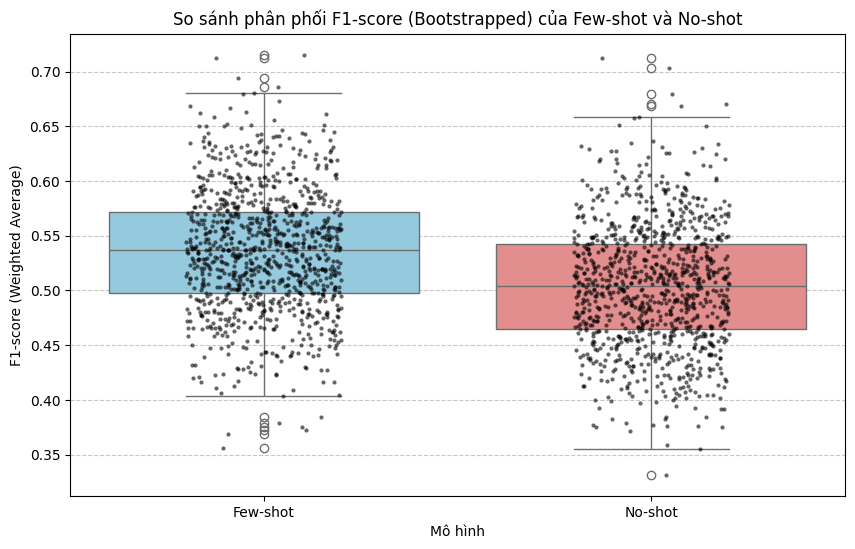

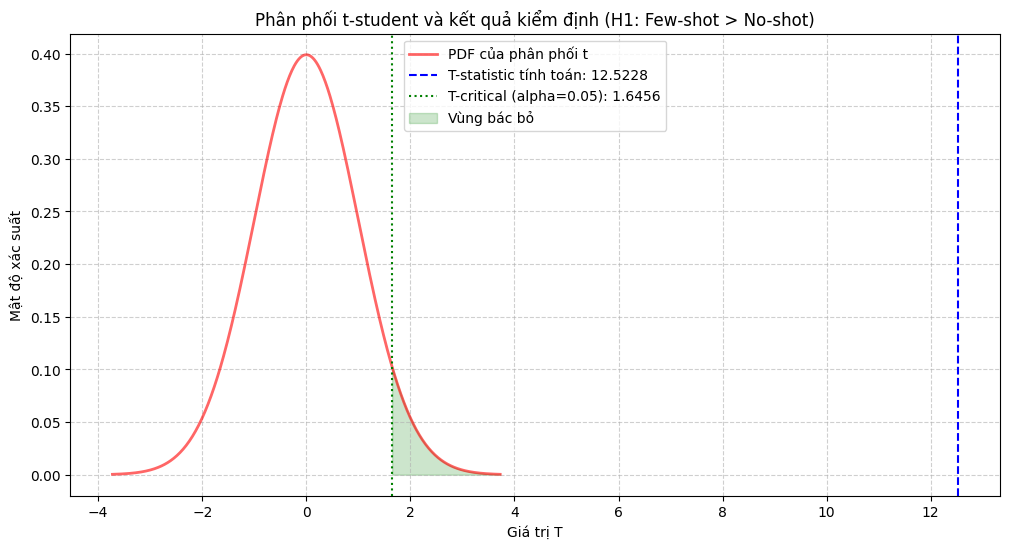

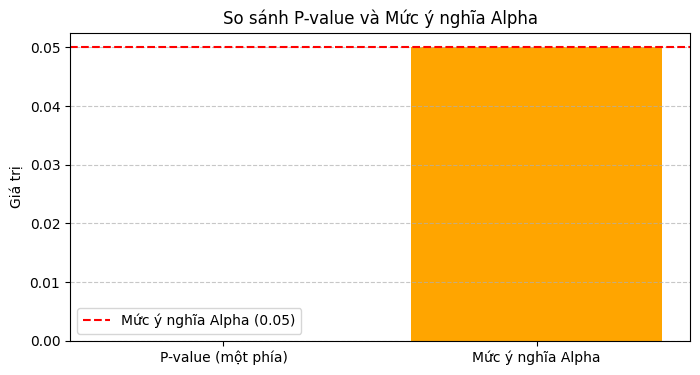


Kết quả T-test:
  Thống kê T: 12.5228
  Giá trị P (một phía): 0.0000
  Kết luận: Bác bỏ H0. Few-shot tốt hơn No-shot một cách có ý nghĩa thống kê (p=0.000000000).


In [30]:
import pandas as pd
import json
import logging
import re
from collections import Counter
import os
from typing import Optional, Dict, Any, List
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from scipy import stats
import seaborn as sns # Import thư viện seaborn
import matplotlib.pyplot as plt # Import thư viện matplotlib để hiển thị biểu đồ

# Cấu hình logger (đảm bảo không bị trùng lặp cấu hình nếu đã có ở các ô khác)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Các hàm hỗ trợ cần thiết cho việc lấy nhãn và tính T-test ---
# (Các hàm này được sao chép từ code trước đó để đảm bảo ô code này độc lập)

def extract_bloom_level(label_string: str) -> str:
    """
    Trích xuất cấp độ Bloom chính từ chuỗi nhãn có thể chứa mô tả.
    Ví dụ: "Remember (Ghi nhớ): Nhớ lại thông tin cơ bản..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    Tải dữ liệu đã gắn nhãn của người và máy, sau đó so sánh các nhãn Bloom.
    Hàm này được tối ưu để chỉ trả về true_labels và predicted_labels cho T-test,
    không in ra các ma trận hay báo cáo chi tiết khác.

    Args:
        human_labeled_path (str): Đường dẫn đến file chứa dữ liệu do người gắn nhãn.
        llm_labeled_path (str): Đường dẫn đến file chứa dữ liệu do LLM gắn nhãn.
        id_column (str): Tên cột chứa ID duy nhất của mỗi mục.
        human_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của người.
        llm_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của máy.

    Returns:
        Optional[Dict[str, Any]]: Một dictionary chứa true_labels và predicted_labels,
                                  hoặc None nếu có lỗi.
    """
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của người tại '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"Lỗi: File dữ liệu của người phải có cột '{id_column}' và '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của người '{human_labeled_path}': {e}", exc_info=True)
        return None

    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"Lỗi: Định dạng file dữ liệu của máy '{llm_labeled_path}' không được hỗ trợ. Chỉ chấp nhận .csv hoặc .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)

    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của máy tại '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"Lỗi: File dữ liệu của máy '{llm_labeled_path}' phải có cột '{id_column}' và '{llm_bloom_label_column}' và định dạng hợp lệ: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của máy '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"Mục '{item_id}': Nhãn Bloom rỗng hoặc không hợp lệ sau khi trích xuất. Bỏ qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"Mục '{item_id}' không có cột nhãn Bloom cần thiết ({e}). Bỏ qua.")
                continue
            except Exception as e:
                logger.warning(f"Lỗi xử lý mục '{item_id}': {e}. Bỏ qua.")
                continue

    if common_items_count == 0:
        logger.warning("Không tìm thấy mục chung nào giữa hai tập dữ liệu hoặc không có nhãn. Không thể tính các metric đồng thuận nhãn Bloom.")
        return None

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_bootstrapped_f1_scores(true_labels: List[str], predicted_labels: List[str], n_bootstraps: int = 1000) -> List[float]:
    """
    Tạo ra phân phối F1-score bằng phương pháp bootstrapping.

    Args:
        true_labels (List[str]): Danh sách nhãn thực tế.
        predicted_labels (List[str]): Danh sách nhãn dự đoán.
        n_bootstraps (int): Số lần lấy mẫu lại.

    Returns:
        List[float]: Danh sách các F1-score tổng thể (weighted avg) từ các mẫu lại.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh sách nhãn thực tế và dự đoán phải có cùng độ dài.")
    
    if not true_labels:
        return []

    f1_scores_distribution = []
    num_samples = len(true_labels)
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze'] # Đảm bảo các nhãn khớp

    for _ in range(n_bootstraps):
        # Lấy mẫu lại các chỉ số với thay thế
        indices = np.random.choice(num_samples, num_samples, replace=True)
        
        # Tạo các mẫu lại của nhãn
        bootstrapped_true = [true_labels[i] for i in indices]
        bootstrapped_pred = [predicted_labels[i] for i in indices]
        
        # Tính F1-score cho mẫu lại
        # Sử dụng zero_division=0 để tránh lỗi khi một lớp không có mẫu nào trong mẫu lại
        report = classification_report(bootstrapped_true, bootstrapped_pred, 
                                       labels=bloom_categories, output_dict=True, zero_division=0)
        
        # Lấy F1-score tổng thể (weighted avg)
        overall_f1 = report['weighted avg']['f1-score']
        f1_scores_distribution.append(overall_f1)
        
    return f1_scores_distribution

def perform_one_tailed_t_test(scores1: List[float], scores2: List[float], scores1_name: str, scores2_name: str, alpha: float = 0.05, hypothesis: str = "greater") -> Dict[str, Any]:
    """
    Thực hiện kiểm định T-test một phía cho hai mẫu độc lập và vẽ biểu đồ so sánh.

    Args:
        scores1 (List[float]): Danh sách điểm số cho nhóm thứ nhất (ví dụ: few-shot).
        scores2 (List[float]): Danh sách điểm số cho nhóm thứ hai (ví dụ: no-shot).
        scores1_name (str): Tên của nhóm thứ nhất (để hiển thị trên biểu đồ).
        scores2_name (str): Tên của nhóm thứ hai (để hiển thị trên biểu đồ).
        alpha (float): Mức ý nghĩa (significance level).
        hypothesis (str): "greater" nếu scores1 > scores2, "less" nếu scores1 < scores2.

    Returns:
        Dict[str, Any]: Dictionary chứa thống kê t, giá trị p, và kết luận.
    """
    if not scores1 or not scores2:
        logger.warning("Không đủ dữ liệu để thực hiện T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Không đủ dữ liệu."}
    
    if len(scores1) < 2 or len(scores2) < 2:
        logger.warning("Cần ít nhất 2 mẫu trong mỗi nhóm để thực hiện T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Không đủ mẫu để thực hiện T-test."}

    # Thực hiện T-test độc lập (Welch's t-test, không giả định phương sai bằng nhau)
    t_statistic, p_value_two_tailed = stats.ttest_ind(scores1, scores2, equal_var=False)

    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)

    conclusion = ""
    p_value_one_tailed = p_value_two_tailed / 2 # Luôn tính p-value một phía

    print(f"\nKiểm định T-test một phía (H1: {scores1_name} tốt hơn {scores2_name}):")
    print(f"  Giá trị trung bình F1-score nhóm {scores1_name}: {mean1:.4f}")
    print(f"  Giá trị trung bình F1-score nhóm {scores2_name}: {mean2:.4f}")
    print(f"  Thống kê T: {t_statistic:.4f}")
    print(f"  Giá trị P (hai phía): {p_value_two_tailed:.9f}") # In 9 chữ số sau dấu phẩy
    print(f"  Giá trị P (một phía): {p_value_one_tailed:.9f}") # In 9 chữ số sau dấu phẩy
    print(f"  Mức ý nghĩa alpha: {alpha}")

    if hypothesis == "greater":
        if t_statistic > 0 and p_value_one_tailed < alpha:
            conclusion = f"Bác bỏ H0. {scores1_name} tốt hơn {scores2_name} một cách có ý nghĩa thống kê (p={p_value_one_tailed:.9f})."
        else:
            conclusion = f"Không đủ bằng chứng để bác bỏ H0. Không có bằng chứng {scores1_name} tốt hơn {scores2_name} một cách có ý nghĩa thống kê (p={p_value_one_tailed:.9f})."
    else:
        conclusion = "Kiểm định không phù hợp với giả thuyết 'greater'."

    # --- Vẽ biểu đồ hộp so sánh phân phối F1-score ---
    plt.figure(figsize=(10, 6))
    data_to_plot = pd.DataFrame({
        'Mô hình': [scores1_name] * len(scores1) + [scores2_name] * len(scores2),
        'F1-score': scores1 + scores2
    })
    sns.boxplot(x='Mô hình', y='F1-score', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})
    sns.stripplot(x='Mô hình', y='F1-score', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6) # Thêm các điểm dữ liệu
    plt.title(f'So sánh phân phối F1-score (Bootstrapped) của {scores1_name} và {scores2_name}')
    plt.ylabel('F1-score (Weighted Average)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- Vẽ biểu đồ phân phối t-student và kết quả kiểm định ---
    plt.figure(figsize=(12, 6))

    # Ước lượng bậc tự do cho t-distribution (cho mục đích trực quan hóa)
    # Với bootstrapping 1000 mẫu, df sẽ rất lớn, gần như phân phối chuẩn.
    df_approx = len(scores1) + len(scores2) - 2 
    if df_approx < 1:
        df_approx = 1 # Đảm bảo df tối thiểu là 1

    x = np.linspace(stats.t.ppf(0.0001, df_approx), stats.t.ppf(0.9999, df_approx), 500)
    plt.plot(x, stats.t.pdf(x, df_approx), 'r-', lw=2, alpha=0.6, label='PDF của phân phối t')

    # Đánh dấu t-statistic được tính toán
    plt.axvline(t_statistic, color='blue', linestyle='--', label=f'T-statistic tính toán: {t_statistic:.4f}')

    # Đánh dấu giá trị t-critical cho kiểm định một phía
    critical_value = stats.t.ppf(1 - alpha, df_approx) # Cho H1: scores1 > scores2
    plt.axvline(critical_value, color='green', linestyle=':', label=f'T-critical (alpha={alpha}): {critical_value:.4f}')

    # Tô màu vùng bác bỏ
    x_rejection = x[x > critical_value]
    plt.fill_between(x_rejection, 0, stats.t.pdf(x_rejection, df_approx), color='green', alpha=0.2, label='Vùng bác bỏ')

    plt.title(f'Phân phối t-student và kết quả kiểm định (H1: {scores1_name} > {scores2_name})')
    plt.xlabel('Giá trị T')
    plt.ylabel('Mật độ xác suất')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- Vẽ biểu đồ so sánh P-value và Alpha ---
    plt.figure(figsize=(8, 4))
    bar_labels = ['P-value (một phía)', 'Mức ý nghĩa Alpha']
    bar_values = [p_value_one_tailed, alpha]
    colors = ['purple' if p_value_one_tailed < alpha else 'orange', 'orange']

    plt.bar(bar_labels, bar_values, color=colors)
    plt.axhline(alpha, color='red', linestyle='--', label=f'Mức ý nghĩa Alpha ({alpha})')
    plt.title('So sánh P-value và Mức ý nghĩa Alpha')
    plt.ylabel('Giá trị')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


    return {
        "t_statistic": t_statistic,
        "p_value_two_tailed": p_value_two_tailed,
        "p_value_one_tailed": p_value_one_tailed,
        "conclusion": conclusion
    }

# --- Cấu hình đường dẫn file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
no_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_no_test102.json"
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- Lấy nhãn từ các file few-shot và no-shot ---
logger.info("\n========== Lấy nhãn để thực hiện T-test (F1-score) ==========")

# Lấy nhãn cho No-Shot
bloom_labels_no_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=no_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# Lấy nhãn cho Few-Shot
bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# --- Thực hiện T-test so sánh Few-Shot và No-Shot ---
logger.info("\n========== Thực hiện Kiểm định T-test so sánh F1-score của Few-Shot và No-Shot ==========")

if bloom_labels_no_shot and bloom_labels_few_shot:
    # Tạo phân phối F1-score bằng bootstrapping
    f1_scores_distribution_no_shot = get_bootstrapped_f1_scores(
        bloom_labels_no_shot['true_labels'],
        bloom_labels_no_shot['predicted_labels']
    )
    f1_scores_distribution_few_shot = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels']
    )

    # Đảm bảo có đủ dữ liệu từ bootstrapping
    if not f1_scores_distribution_no_shot or not f1_scores_distribution_few_shot:
        logger.error("Không đủ dữ liệu F1-score từ bootstrapping để thực hiện T-test.")
    else:
        # Thực hiện T-test một phía (H1: few-shot tốt hơn no-shot)
        t_test_results = perform_one_tailed_t_test(
            scores1=f1_scores_distribution_few_shot, # Nhóm 1: Few-shot
            scores2=f1_scores_distribution_no_shot,  # Nhóm 2: No-shot
            scores1_name="Few-shot", # Tên cho biểu đồ
            scores2_name="No-shot",  # Tên cho biểu đồ
            hypothesis="greater" # Giả thuyết: Few-shot tốt hơn No-shot
        )
        print(f"\nKết quả T-test:")
        print(f"  Thống kê T: {t_test_results['t_statistic']:.4f}")
        print(f"  Giá trị P (một phía): {t_test_results['p_value_one_tailed']:.4f}")
        print(f"  Kết luận: {t_test_results['conclusion']}")
else:
    logger.error("Không đủ kết quả đánh giá nhãn Bloom từ cả hai mô hình để thực hiện T-test.")


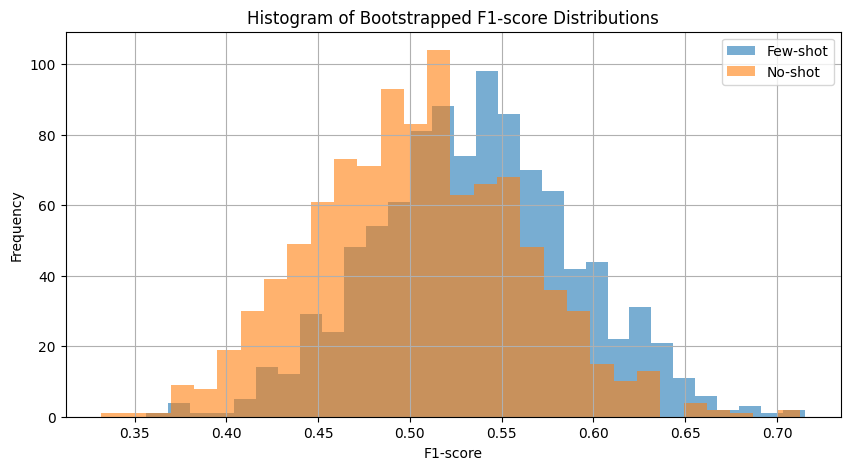

In [31]:
plt.figure(figsize=(10, 5))
plt.hist(f1_scores_distribution_few_shot, bins=30, alpha=0.6, label='Few-shot')
plt.hist(f1_scores_distribution_no_shot, bins=30, alpha=0.6, label='No-shot')
plt.title('Histogram of Bootstrapped F1-score Distributions')
plt.xlabel('F1-score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
print("📊 Few-shot F1 samples (10):", f1_scores_distribution_few_shot[:10])
print("📊 No-shot  F1 samples (10):", f1_scores_distribution_no_shot[:10])


📊 Few-shot F1 samples (10): [0.5493369215818196, 0.5250385579332948, 0.5400552875800401, 0.4679736002448223, 0.5660061919504643, 0.5874009178139341, 0.5140540533695666, 0.5046722856668973, 0.5818748003832641, 0.35605987678090106]
📊 No-shot  F1 samples (10): [0.5677838102624811, 0.5092403335125388, 0.5294375591405295, 0.41103146853146855, 0.5203883495145631, 0.5882785839149725, 0.5169533310400184, 0.510522032321823, 0.5753676470588236, 0.5815710209781185]


In [33]:
print(f"🔢 Số mẫu bootstrapped: Few-shot = {len(f1_scores_distribution_few_shot)}, No-shot = {len(f1_scores_distribution_no_shot)}")
print(f"📈 Few-shot: Min = {min(f1_scores_distribution_few_shot):.4f}, Max = {max(f1_scores_distribution_few_shot):.4f}")
print(f"📉 No-shot : Min = {min(f1_scores_distribution_no_shot):.4f}, Max = {max(f1_scores_distribution_no_shot):.4f}")


🔢 Số mẫu bootstrapped: Few-shot = 1000, No-shot = 1000
📈 Few-shot: Min = 0.3561, Max = 0.7154
📉 No-shot : Min = 0.3316, Max = 0.7125


In [35]:
import numpy as np

def compute_cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    pooled_std = np.sqrt((std1 ** 2 + std2 ** 2) / 2)
    d = (mean1 - mean2) / pooled_std
    return d

cohen_d = compute_cohens_d(f1_scores_distribution_few_shot, f1_scores_distribution_no_shot)
print(f"Cohen's d: {cohen_d:.4f}")


Cohen's d: 0.5600


Trung bình độ chính xác Softmax: 0.6598
Trung bình độ chính xác Random Forest: 0.6644
T-statistic = -0.1939
P-value = 0.8506
⚠️ Kết luận: KHÔNG có sự khác biệt có ý nghĩa thống kê giữa Softmax và Random Forest.


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\3504810395.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([softmax_val_acc, rf_val_acc], labels=["Softmax", "Random Forest"])


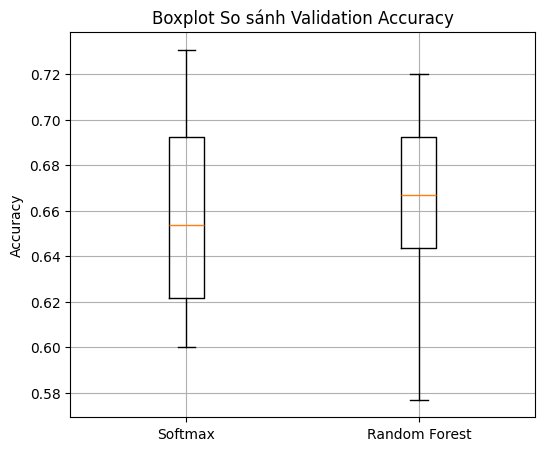

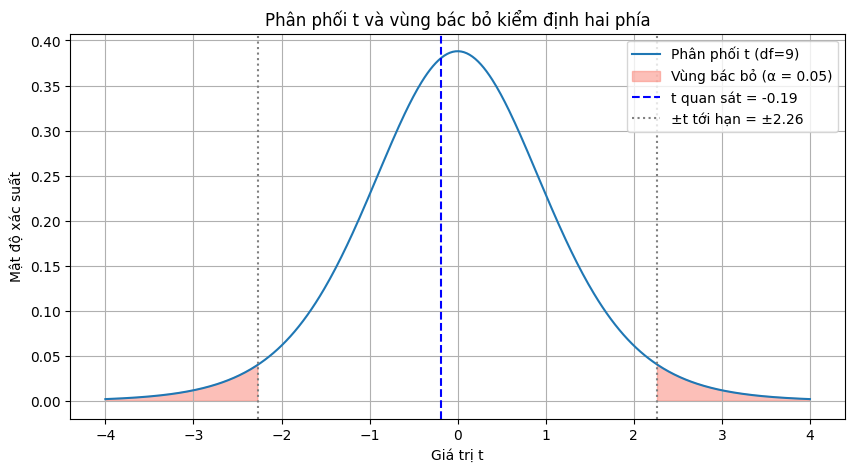

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, t

# ======= Dữ liệu =======
softmax_val_acc = [0.6923, 0.6154, 0.7308, 0.6538, 0.6538,
                   0.6923, 0.6000, 0.7200, 0.6400, 0.6000]
rf_val_acc = [0.6923, 0.6538, 0.6154, 0.5769, 0.6538,
              0.6923, 0.7200, 0.6800, 0.6400, 0.7200]

# ======= Tính trung bình & kiểm định T-test =======
mean_softmax = np.mean(softmax_val_acc)
mean_rf = np.mean(rf_val_acc)
t_stat, p_value = ttest_rel(softmax_val_acc, rf_val_acc)

# ======= In kết quả và KẾT LUẬN =======
print(f"Trung bình độ chính xác Softmax: {mean_softmax:.4f}")
print(f"Trung bình độ chính xác Random Forest: {mean_rf:.4f}")
print(f"T-statistic = {t_stat:.4f}")
print(f"P-value = {p_value:.4f}")

# ======= KẾT LUẬN =======
alpha = 0.05
if p_value < alpha:
    if mean_rf > mean_softmax:
        print("✅ Kết luận: Random Forest có độ chính xác cao hơn và sự khác biệt này CÓ ý nghĩa thống kê.")
    else:
        print("✅ Kết luận: Softmax có độ chính xác cao hơn và sự khác biệt này CÓ ý nghĩa thống kê.")
else:
    print("⚠️ Kết luận: KHÔNG có sự khác biệt có ý nghĩa thống kê giữa Softmax và Random Forest.")

# ======= Boxplot =======
plt.figure(figsize=(6, 5))
plt.boxplot([softmax_val_acc, rf_val_acc], labels=["Softmax", "Random Forest"])
plt.title("Boxplot So sánh Validation Accuracy")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# ======= Vẽ phân phối t với vùng bác bỏ =======
df = len(softmax_val_acc) - 1
t_crit = t.ppf(1 - alpha/2, df)
x = np.linspace(-4, 4, 500)
y = t.pdf(x, df)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label=f"Phân phối t (df={df})")
plt.fill_between(x, y, where=(x <= -t_crit) | (x >= t_crit), color='salmon', alpha=0.5, label="Vùng bác bỏ (α = 0.05)")
plt.axvline(t_stat, color='blue', linestyle='--', label=f"t quan sát = {t_stat:.2f}")
plt.axvline(-t_crit, color='gray', linestyle=':', label=f"±t tới hạn = ±{t_crit:.2f}")
plt.axvline(t_crit, color='gray', linestyle=':')
plt.title("Phân phối t và vùng bác bỏ kiểm định hai phía")
plt.xlabel("Giá trị t")
plt.ylabel("Mật độ xác suất")
plt.legend()
plt.grid(True)
plt.show()



===> T-TEST SOFTMAX vs RANDOM FOREST:
Trung bình Softmax: 0.6598
Trung bình Random Forest: 0.6644
T-statistic = -0.1939, P-value = 0.8506
⚠️ Kết luận: Không có sự khác biệt có ý nghĩa thống kê giữa hai mô hình.

===> ANOVA kiểm định sự khác biệt giữa các nhóm fold:
F-statistic = 0.0488, P-value = 0.8277
⚠️ Kết luận ANOVA: Không có sự khác biệt đáng kể giữa các fold.


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\89696658.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([softmax_val_acc, rf_val_acc], labels=["Softmax", "Random Forest"])


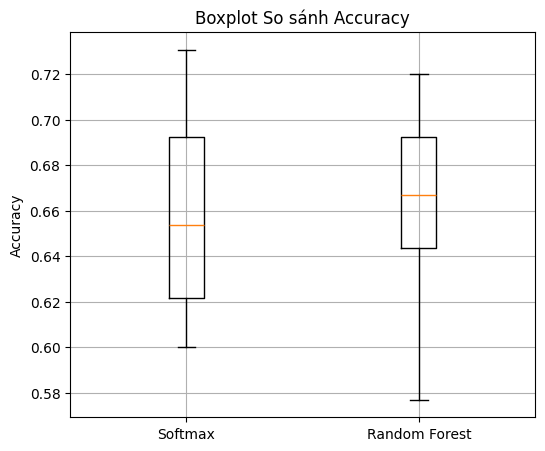

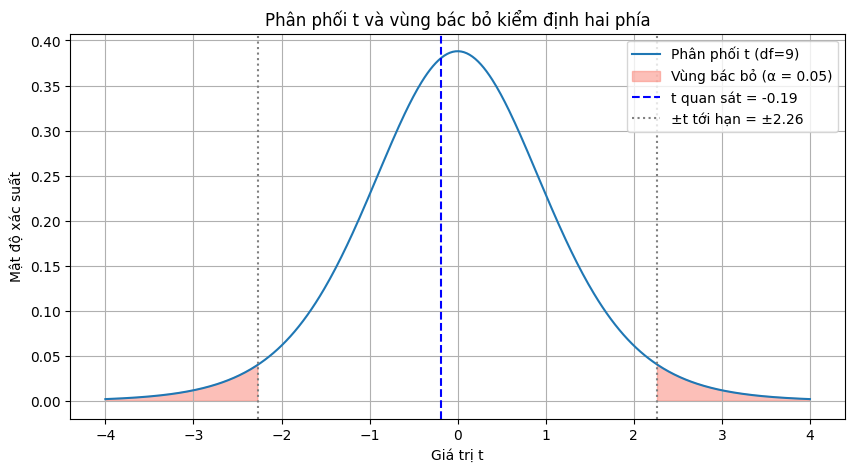

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, t, f_oneway

# ======= Dữ liệu =======
softmax_val_acc = [0.6923, 0.6154, 0.7308, 0.6538, 0.6538,
                   0.6923, 0.6000, 0.7200, 0.6400, 0.6000]
rf_val_acc = [0.6923, 0.6538, 0.6154, 0.5769, 0.6538,
              0.6923, 0.7200, 0.6800, 0.6400, 0.7200]

# ======= Trung bình và T-test =======
mean_softmax = np.mean(softmax_val_acc)
mean_rf = np.mean(rf_val_acc)
t_stat, p_value = ttest_rel(softmax_val_acc, rf_val_acc)

print(f"\n===> T-TEST SOFTMAX vs RANDOM FOREST:")
print(f"Trung bình Softmax: {mean_softmax:.4f}")
print(f"Trung bình Random Forest: {mean_rf:.4f}")
print(f"T-statistic = {t_stat:.4f}, P-value = {p_value:.4f}")

# ======= Kết luận T-test =======
alpha = 0.05
if p_value < alpha:
    better_model = "Random Forest" if mean_rf > mean_softmax else "Softmax"
    print(f"✅ Kết luận: {better_model} tốt hơn và sự khác biệt có ý nghĩa thống kê.")
else:
    print("⚠️ Kết luận: Không có sự khác biệt có ý nghĩa thống kê giữa hai mô hình.")

# ======= ANOVA để so sánh các fold =======
anova_stat, anova_p = f_oneway(softmax_val_acc, rf_val_acc)

print(f"\n===> ANOVA kiểm định sự khác biệt giữa các nhóm fold:")
print(f"F-statistic = {anova_stat:.4f}, P-value = {anova_p:.4f}")

if anova_p < alpha:
    print("✅ Kết luận ANOVA: Có ít nhất một nhóm (fold) có kết quả khác biệt có ý nghĩa thống kê.")
else:
    print("⚠️ Kết luận ANOVA: Không có sự khác biệt đáng kể giữa các fold.")

# ======= Boxplot so sánh hai mô hình =======
plt.figure(figsize=(6, 5))
plt.boxplot([softmax_val_acc, rf_val_acc], labels=["Softmax", "Random Forest"])
plt.title("Boxplot So sánh Accuracy")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# ======= Biểu đồ phân phối t và vùng bác bỏ =======
df = len(softmax_val_acc) - 1
t_crit = t.ppf(1 - alpha/2, df)
x = np.linspace(-4, 4, 500)
y = t.pdf(x, df)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label=f"Phân phối t (df={df})")
plt.fill_between(x, y, where=(x <= -t_crit) | (x >= t_crit), color='salmon', alpha=0.5, label="Vùng bác bỏ (α = 0.05)")
plt.axvline(t_stat, color='blue', linestyle='--', label=f"t quan sát = {t_stat:.2f}")
plt.axvline(-t_crit, color='gray', linestyle=':', label=f"±t tới hạn = ±{t_crit:.2f}")
plt.axvline(t_crit, color='gray', linestyle=':')
plt.title("Phân phối t và vùng bác bỏ kiểm định hai phía")
plt.xlabel("Giá trị t")
plt.ylabel("Mật độ xác suất")
plt.legend()
plt.grid(True)
plt.show()


2025-07-01 23:35:20,714 - INFO - 
========== Lấy nhãn và tạo phân phối F1-score cho LLM Few-Shot ==========
2025-07-01 23:35:20,810 - INFO - Đã tạo 10 mẫu F1-score cho LLM Few-shot bằng bootstrapping.
2025-07-01 23:35:20,811 - INFO - 
========== Thực hiện Kiểm định ANOVA so sánh F1-score của LLM Few-Shot, Softmax và Random Forest ==========
C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\4159445413.py:245: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mô hình', y='F1-score', data=data_for_boxplot,



===> Kết quả kiểm định ANOVA giữa LLM Few-Shot, Softmax và Random Forest:
F-statistic: 30.0563
P-value: 0.000000136
✅ Kết luận: Có ít nhất một nhóm có kết quả F1-score khác biệt có ý nghĩa thống kê (p < 0.05).
   (Dựa trên giá trị trung bình, LLM Few-shot (0.5385) có vẻ vượt trội hơn Softmax (0.3662) và Random Forest (0.2732).)
   Để xác nhận LLM Few-shot vượt trội hơn CỤ THỂ từng mô hình, cần thực hiện kiểm định Post-hoc.


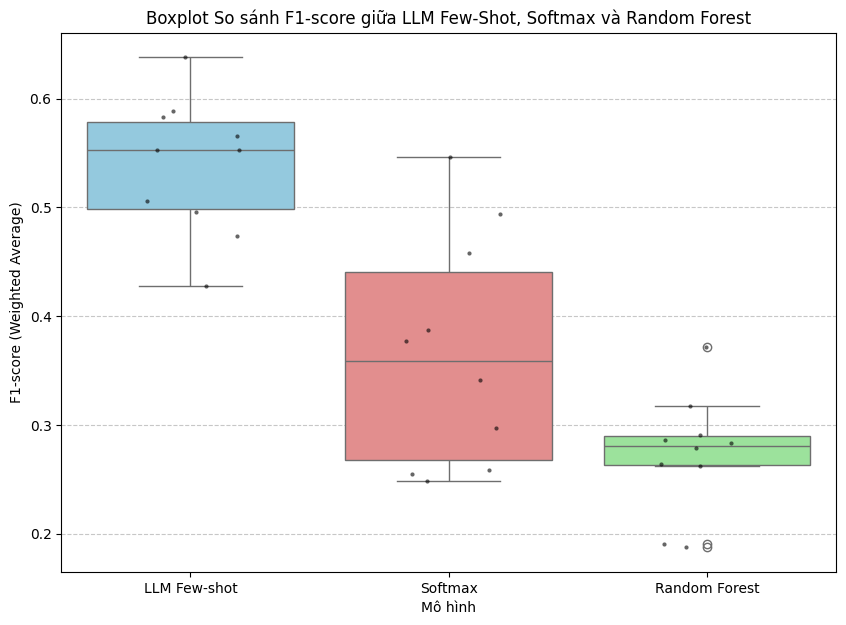

In [21]:
import pandas as pd
import json
import logging
import re
from collections import Counter
import numpy as np
from scipy import stats
from scipy.stats import f_oneway # Import f_oneway for ANOVA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Cấu hình logger (đảm bảo không bị trùng lặp cấu hình nếu đã có ở các ô khác)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Các hàm hỗ trợ cần thiết cho việc lấy nhãn và tính toán ---

def extract_bloom_level(label_string: str) -> str:
    """
    Trích xuất cấp độ Bloom chính từ chuỗi nhãn có thể chứa mô tả.
    Ví dụ: "Remember (Ghi nhớ): Nhớ lại thông tin cơ bản..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    Tải dữ liệu đã gắn nhãn của người và máy, sau đó so sánh các nhãn Bloom.
    Hàm này được tối ưu để chỉ trả về true_labels và predicted_labels cho các kiểm định thống kê,
    không in ra các ma trận hay báo cáo chi tiết khác.

    Args:
        human_labeled_path (str): Đường dẫn đến file chứa dữ liệu do người gắn nhãn.
                                   Hỗ trợ CSV.
        llm_labeled_path (str): Đường dẫn đến file chứa dữ liệu do LLM gắn nhãn.
                                  Hỗ trợ CSV hoặc JSON.
        id_column (str): Tên cột chứa ID duy nhất của mỗi mục.
        human_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của người.
        llm_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của máy.

    Returns:
        Optional[Dict[str, Any]]: Một dictionary chứa true_labels và predicted_labels,
                                  hoặc None nếu có lỗi.
    """
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của người tại '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"Lỗi: File dữ liệu của người phải có cột '{id_column}' và '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của người '{human_labeled_path}': {e}", exc_info=True)
        return None

    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"Lỗi: Định dạng file dữ liệu của máy '{llm_labeled_path}' không được hỗ trợ. Chỉ chấp nhận .csv hoặc .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)

    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của máy tại '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"Lỗi: File dữ liệu của máy '{llm_labeled_path}' phải có cột '{id_column}' và '{llm_bloom_label_column}' và định dạng hợp lệ: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của máy '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"Mục '{item_id}': Nhãn Bloom rỗng hoặc không hợp lệ sau khi trích xuất. Bỏ qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"Mục '{item_id}' không có cột nhãn Bloom cần thiết ({e}). Bỏ qua.")
                continue
            except Exception as e:
                logger.warning(f"Lỗi xử lý mục '{item_id}': {e}. Bỏ qua.")
                continue

    if common_items_count == 0:
        logger.warning("Không tìm thấy mục chung nào giữa hai tập dữ liệu hoặc không có nhãn. Không thể tính các metric đồng thuận nhãn Bloom.")
        return None

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_bootstrapped_f1_scores(true_labels: List[str], predicted_labels: List[str], n_bootstraps: int = 10) -> List[float]:
    """
    Tạo ra phân phối F1-score bằng phương pháp bootstrapping.

    Args:
        true_labels (List[str]): Danh sách nhãn thực tế.
        predicted_labels (List[str]): Danh sách nhãn dự đoán.
        n_bootstraps (int): Số lần lấy mẫu lại.

    Returns:
        List[float]: Danh sách các F1-score tổng thể (weighted avg) từ các mẫu lại.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh sách nhãn thực tế và dự đoán phải có cùng độ dài.")
    
    if not true_labels:
        return []

    f1_scores_distribution = []
    num_samples = len(true_labels)
    # Đảm bảo các nhãn khớp với các nhãn có thể có trong dữ liệu Bloom
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze'] 

    for _ in range(n_bootstraps):
        # Lấy mẫu lại các chỉ số với thay thế
        indices = np.random.choice(num_samples, num_samples, replace=True)
        
        # Tạo các mẫu lại của nhãn
        bootstrapped_true = [true_labels[i] for i in indices]
        bootstrapped_pred = [predicted_labels[i] for i in indices]
        
        # Tính F1-score cho mẫu lại
        # Sử dụng zero_division=0 để tránh lỗi khi một lớp không có mẫu nào trong mẫu lại
        report = classification_report(bootstrapped_true, bootstrapped_pred, 
                                       labels=bloom_categories, output_dict=True, zero_division=0)
        
        # Lấy F1-score tổng thể (weighted avg)
        overall_f1 = report['weighted avg']['f1-score']
        f1_scores_distribution.append(overall_f1)
        
    return f1_scores_distribution

# --- Cấu hình đường dẫn file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- Dữ liệu F1-score của các mô hình ML (được cập nhật từ dữ liệu bạn cung cấp) ---
# Đây là F1-macro scores từ 10 folds của bạn
softmax_val_f1 = [0.5460, 0.2583, 0.4583, 0.3772, 0.2548,
                  0.4940, 0.2968, 0.3876, 0.2482, 0.3412] 
rf_val_f1 = [0.3718, 0.2625, 0.1905, 0.3173, 0.2857,
             0.2787, 0.2907, 0.2833, 0.1875, 0.2637] 

# --- Lấy nhãn từ file LLM Few-Shot và tạo phân phối F1-score ---
logger.info("\n========== Lấy nhãn và tạo phân phối F1-score cho LLM Few-Shot ==========")

bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

if bloom_labels_few_shot:
    f1_distribution_few_shot = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels'],
        n_bootstraps=10 # Đặt số lần bootstrap là 10
    )
    logger.info(f"Đã tạo {len(f1_distribution_few_shot)} mẫu F1-score cho LLM Few-shot bằng bootstrapping.")
else:
    logger.error("Không thể tạo phân phối F1-score cho LLM Few-Shot. Không thể thực hiện kiểm định.")
    f1_distribution_few_shot = [] # Đặt rỗng để tránh lỗi

# --- Thực hiện Kiểm định ANOVA ---
logger.info("\n========== Thực hiện Kiểm định ANOVA so sánh F1-score của LLM Few-Shot, Softmax và Random Forest ==========")

# Đảm bảo có đủ dữ liệu từ tất cả các nhóm
if f1_distribution_few_shot and softmax_val_f1 and rf_val_f1:
    # Thực hiện ANOVA
    anova_f_statistic, anova_p_value = f_oneway(f1_distribution_few_shot, softmax_val_f1, rf_val_f1)

    print(f"\n===> Kết quả kiểm định ANOVA giữa LLM Few-Shot, Softmax và Random Forest:")
    print(f"F-statistic: {anova_f_statistic:.4f}")
    print(f"P-value: {anova_p_value:.9f}") # In p-value với độ chính xác cao hơn

    # Kết luận cho ANOVA (kiểm định hai phía)
    if anova_p_value < 0.05:
        print("✅ Kết luận: Có ít nhất một nhóm có kết quả F1-score khác biệt có ý nghĩa thống kê (p < 0.05).")
        
        mean_llm_few_shot = np.mean(f1_distribution_few_shot)
        mean_softmax = np.mean(softmax_val_f1)
        mean_rf = np.mean(rf_val_f1)

        # Kiểm tra xem LLM Few-shot có giá trị trung bình cao nhất không
        if mean_llm_few_shot > mean_softmax and mean_llm_few_shot > mean_rf:
            print(f"   (Dựa trên giá trị trung bình, LLM Few-shot ({mean_llm_few_shot:.4f}) có vẻ vượt trội hơn Softmax ({mean_softmax:.4f}) và Random Forest ({mean_rf:.4f}).)")
            print("   Để xác nhận LLM Few-shot vượt trội hơn CỤ THỂ từng mô hình, cần thực hiện kiểm định Post-hoc.")
        else:
            print("   (Cần thực hiện kiểm định Post-hoc để xác định nhóm nào khác biệt và theo hướng nào.)")
    else:
        print("⚠️ Kết luận: Không có sự khác biệt đáng kể về F1-score giữa các nhóm (p >= 0.05).")

    # ======= Vẽ boxplot so sánh F1-score =======
    plt.figure(figsize=(10, 7))
    
    # Chuẩn bị dữ liệu cho boxplot
    data_for_boxplot = pd.DataFrame({
        'Mô hình': ['LLM Few-shot'] * len(f1_distribution_few_shot) +
                   ['Softmax'] * len(softmax_val_f1) +
                   ['Random Forest'] * len(rf_val_f1),
        'F1-score': f1_distribution_few_shot + softmax_val_f1 + rf_val_f1
    })

    sns.boxplot(x='Mô hình', y='F1-score', data=data_for_boxplot, 
                palette={'LLM Few-shot': 'skyblue', 'Softmax': 'lightcoral', 'Random Forest': 'lightgreen'})
    sns.stripplot(x='Mô hình', y='F1-score', data=data_for_boxplot, color='black', size=3, jitter=0.2, alpha=0.6)
    
    plt.title("Boxplot So sánh F1-score giữa LLM Few-Shot, Softmax và Random Forest")
    plt.ylabel("F1-score (Weighted Average)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

else:
    logger.error("Không đủ dữ liệu từ một hoặc nhiều nhóm để thực hiện kiểm định ANOVA.")



===> T-TEST SOFTMAX vs RANDOM FOREST (F1-score):
Trung bình Softmax (F1-macro): 0.3662
Trung bình Random Forest (F1-macro): 0.2732
T-statistic = 2.9941, P-value = 0.015100688
✅ Kết luận: Softmax tốt hơn và sự khác biệt có ý nghĩa thống kê về F1-score (p=0.015100688).


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\123739120.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mô hình', y='F1-score', data=data_to_plot, palette={'Softmax': 'lightcoral', 'Random Forest': 'lightgreen'})


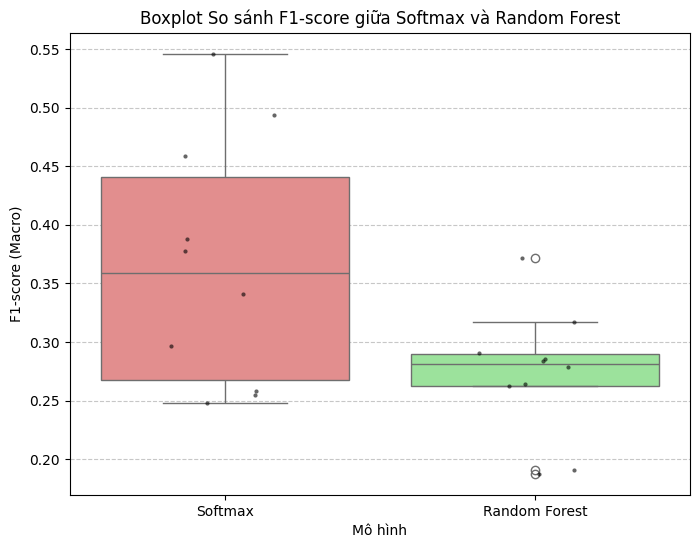

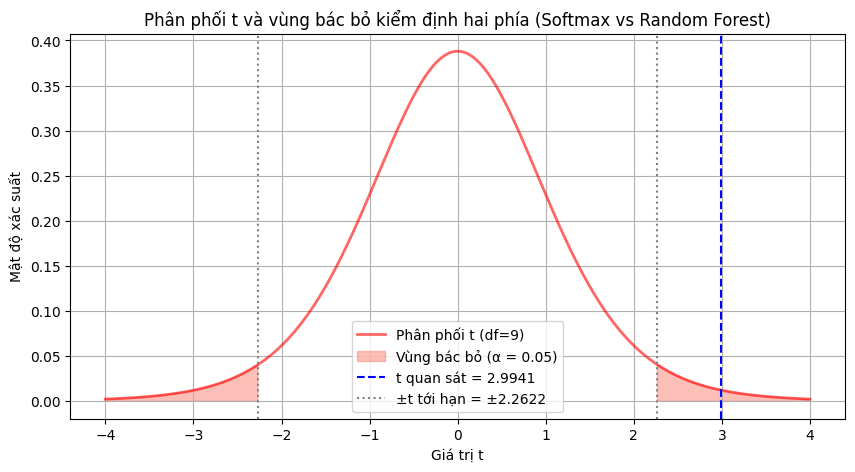

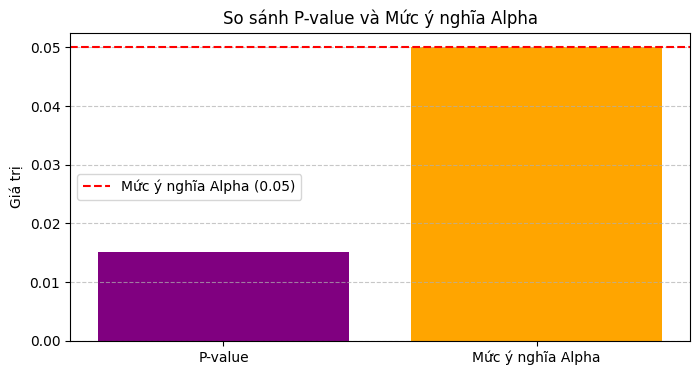

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, t, f_oneway # f_oneway is imported but not used for this specific request
import pandas as pd # Imported for general utility, not strictly needed for this specific code block
import logging
import seaborn as sns

# Cấu hình logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Dữ liệu F1-score của các mô hình ML (F1-macro scores từ 10 folds) ---
softmax_val_f1 = [0.5460, 0.2583, 0.4583, 0.3772, 0.2548,
                  0.4940, 0.2968, 0.3876, 0.2482, 0.3412] 
rf_val_f1 = [0.3718, 0.2625, 0.1905, 0.3173, 0.2857,
             0.2787, 0.2907, 0.2833, 0.1875, 0.2637] 

# --- Kiểm định T-test giữa Softmax và Random Forest ---
# Sử dụng ttest_rel vì đây là dữ liệu từ các fold (có thể coi là cặp)
mean_softmax = np.mean(softmax_val_f1)
mean_rf = np.mean(rf_val_f1)
t_stat, p_value = ttest_rel(softmax_val_f1, rf_val_f1)

print(f"\n===> T-TEST SOFTMAX vs RANDOM FOREST (F1-score):")
print(f"Trung bình Softmax (F1-macro): {mean_softmax:.4f}")
print(f"Trung bình Random Forest (F1-macro): {mean_rf:.4f}")
print(f"T-statistic = {t_stat:.4f}, P-value = {p_value:.9f}") # In p-value với độ chính xác cao hơn

# ======= Kết luận T-test =======
alpha = 0.05
if p_value < alpha:
    # Xác định mô hình nào tốt hơn dựa trên giá trị trung bình
    better_model = "Random Forest" if mean_rf > mean_softmax else "Softmax"
    print(f"✅ Kết luận: {better_model} tốt hơn và sự khác biệt có ý nghĩa thống kê về F1-score (p={p_value:.9f}).")
else:
    print(f"⚠️ Kết luận: Không có sự khác biệt có ý nghĩa thống kê về F1-score giữa hai mô hình Softmax và Random Forest (p={p_value:.9f}).")

# ======= Boxplot so sánh hai mô hình =======
plt.figure(figsize=(8, 6))
data_to_plot = pd.DataFrame({
    'Mô hình': ['Softmax'] * len(softmax_val_f1) + ['Random Forest'] * len(rf_val_f1),
    'F1-score': softmax_val_f1 + rf_val_f1
})
sns.boxplot(x='Mô hình', y='F1-score', data=data_to_plot, palette={'Softmax': 'lightcoral', 'Random Forest': 'lightgreen'})
sns.stripplot(x='Mô hình', y='F1-score', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6)
plt.title("Boxplot So sánh F1-score giữa Softmax và Random Forest")
plt.ylabel("F1-score (Macro)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ======= Biểu đồ phân phối t và vùng bác bỏ =======
# Bậc tự do cho paired t-test là n - 1, với n là số cặp (số folds)
df = len(softmax_val_f1) - 1 
t_crit = stats.t.ppf(1 - alpha/2, df) # t-critical cho kiểm định hai phía
x = np.linspace(-4, 4, 500) # Phạm vi giá trị t để vẽ
y = stats.t.pdf(x, df) # Mật độ xác suất của phân phối t

plt.figure(figsize=(10, 5))
plt.plot(x, y, label=f"Phân phối t (df={df})", color='red', lw=2, alpha=0.6)
# Tô màu vùng bác bỏ (hai phía)
plt.fill_between(x, y, where=(x <= -t_crit) | (x >= t_crit), color='salmon', alpha=0.5, label="Vùng bác bỏ (α = 0.05)")
# Vẽ đường t-statistic quan sát
plt.axvline(t_stat, color='blue', linestyle='--', label=f"t quan sát = {t_stat:.4f}")
# Vẽ đường t-critical
plt.axvline(-t_crit, color='gray', linestyle=':', label=f"±t tới hạn = ±{t_crit:.4f}")
plt.axvline(t_crit, color='gray', linestyle=':')

plt.title("Phân phối t và vùng bác bỏ kiểm định hai phía (Softmax vs Random Forest)")
plt.xlabel("Giá trị t")
plt.ylabel("Mật độ xác suất")
plt.legend()
plt.grid(True)
plt.show()

# ======= Biểu đồ so sánh P-value và Alpha =======
plt.figure(figsize=(8, 4))
bar_labels = ['P-value', 'Mức ý nghĩa Alpha']
bar_values = [p_value, alpha]
colors = ['purple' if p_value < alpha else 'orange', 'orange']

plt.bar(bar_labels, bar_values, color=colors)
plt.axhline(alpha, color='red', linestyle='--', label=f'Mức ý nghĩa Alpha ({alpha})')
plt.title('So sánh P-value và Mức ý nghĩa Alpha')
plt.ylabel('Giá trị')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


2025-07-01 23:53:47,860 - INFO - 
========== Lấy nhãn và tạo phân phối F1-score cho LLM Few-Shot ==========
2025-07-01 23:53:47,944 - INFO - Đã tạo 10 mẫu F1-score cho LLM Few-shot bằng bootstrapping.
2025-07-01 23:53:47,945 - INFO - 
========== Thực hiện Kiểm định T-test so sánh F1-score của LLM Few-Shot và Softmax ==========
C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\179666543.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mô hình', y='F1-score', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})



Kiểm định T-test một phía (H1: LLM Few-shot tốt hơn Softmax):
  Giá trị trung bình F1-score nhóm LLM Few-shot: 0.5366
  Giá trị trung bình F1-score nhóm Softmax: 0.3662
  Thống kê T: 4.8550
  Giá trị P (hai phía): 0.000548858
  Giá trị P (một phía): 0.000274429
  Mức ý nghĩa alpha: 0.05


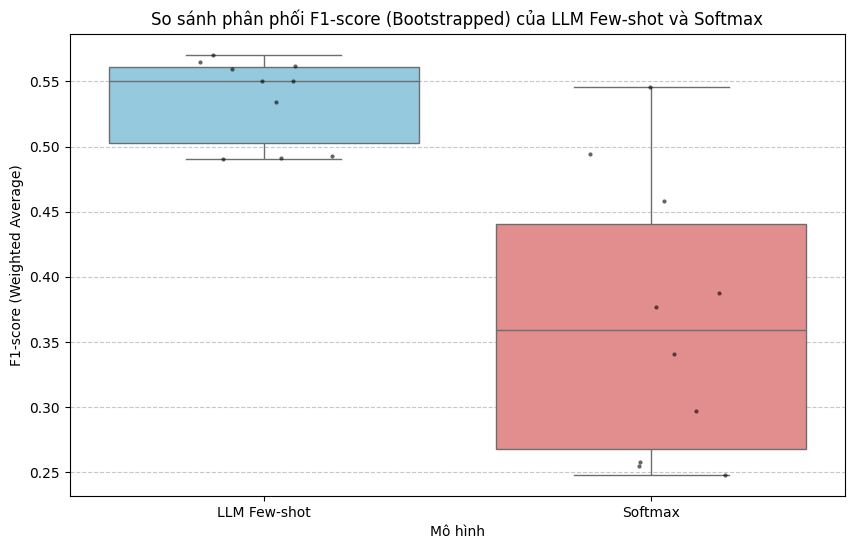

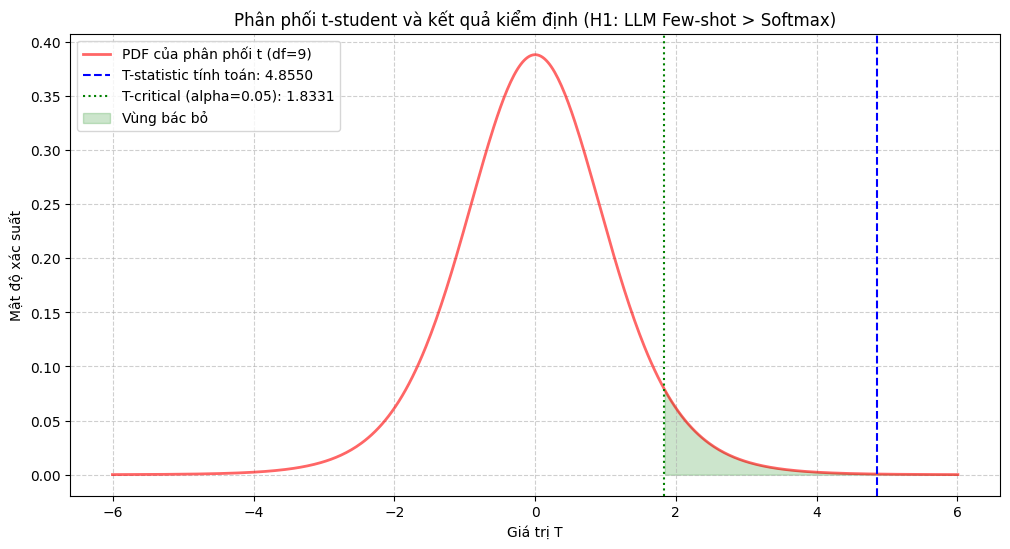

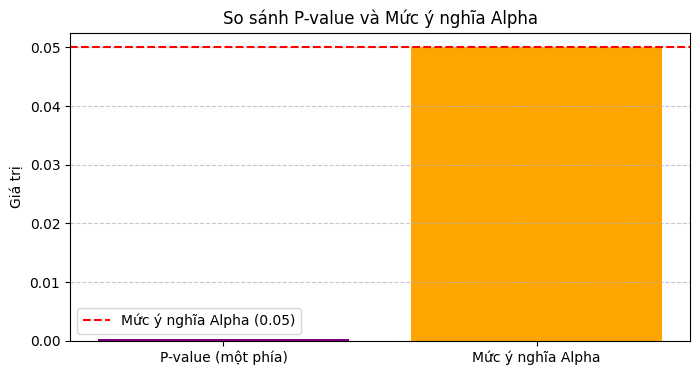


Kết quả T-test (LLM Few-shot vs Softmax):
  Thống kê T: 4.8550
  Giá trị P (một phía): 0.0003
  Kết luận: Bác bỏ H0. LLM Few-shot tốt hơn Softmax một cách có ý nghĩa thống kê (p=0.000274429).


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\179666543.py:336: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mô hình', y='F1-score', data=data_for_boxplot,


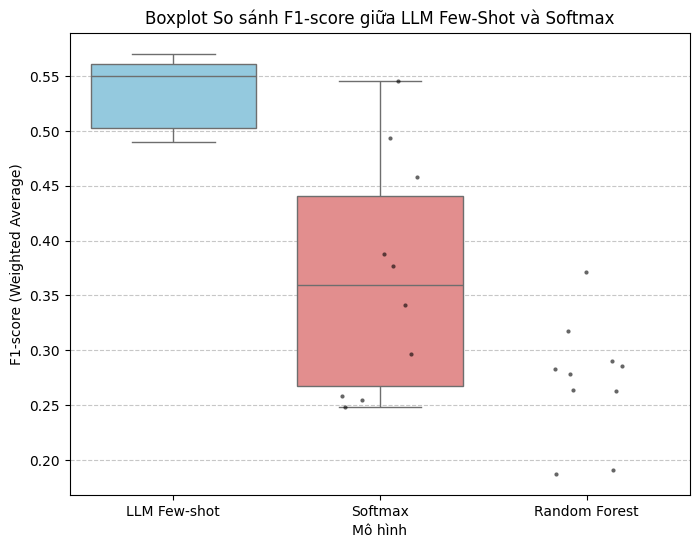

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, t # Changed to ttest_ind for independent samples if needed, but will use ttest_rel if data is paired
import pandas as pd 
import logging
import seaborn as sns
from sklearn.metrics import classification_report # Needed for F1-score calculation in bootstrapping
from typing import Optional, Dict, Any, List
import json
import re

# Cấu hình logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Các hàm hỗ trợ cần thiết cho việc lấy nhãn và tính toán ---

def extract_bloom_level(label_string: str) -> str:
    """
    Trích xuất cấp độ Bloom chính từ chuỗi nhãn có thể chứa mô tả.
    Ví dụ: "Remember (Ghi nhớ): Nhớ lại thông tin cơ bản..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    Tải dữ liệu đã gắn nhãn của người và máy, sau đó so sánh các nhãn Bloom.
    Hàm này được tối ưu để chỉ trả về true_labels và predicted_labels cho các kiểm định thống kê,
    không in ra các ma trận hay báo cáo chi tiết khác.

    Args:
        human_labeled_path (str): Đường dẫn đến file chứa dữ liệu do người gắn nhãn.
                                   Hỗ trợ CSV.
        llm_labeled_path (str): Đường dẫn đến file chứa dữ liệu do LLM gắn nhãn.
                                  Hỗ trợ CSV hoặc JSON.
        id_column (str): Tên cột chứa ID duy nhất của mỗi mục.
        human_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của người.
        llm_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của máy.

    Returns:
        Optional[Dict[str, Any]]: Một dictionary chứa true_labels và predicted_labels,
                                  hoặc None nếu có lỗi.
    """
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của người tại '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"Lỗi: File dữ liệu của người phải có cột '{id_column}' và '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của người '{human_labeled_path}': {e}", exc_info=True)
        return None

    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"Lỗi: Định dạng file dữ liệu của máy '{llm_labeled_path}' không được hỗ trợ. Chỉ chấp nhận .csv hoặc .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)

    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của máy tại '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"Lỗi: File dữ liệu của máy '{llm_labeled_path}' phải có cột '{id_column}' và '{llm_bloom_label_column}' và định dạng hợp lệ: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của máy '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"Mục '{item_id}': Nhãn Bloom rỗng hoặc không hợp lệ sau khi trích xuất. Bỏ qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"Mục '{item_id}' không có cột nhãn Bloom cần thiết ({e}). Bỏ qua.")
                continue
            except Exception as e:
                logger.warning(f"Lỗi xử lý mục '{item_id}': {e}. Bỏ qua.")
                continue

    if common_items_count == 0:
        logger.warning("Không tìm thấy mục chung nào giữa hai tập dữ liệu hoặc không có nhãn. Không thể tính các metric đồng thuận nhãn Bloom.")
        return None

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_bootstrapped_f1_scores(true_labels: List[str], predicted_labels: List[str], n_bootstraps: int = 10) -> List[float]:
    """
    Tạo ra phân phối F1-score bằng phương pháp bootstrapping.

    Args:
        true_labels (List[str]): Danh sách nhãn thực tế.
        predicted_labels (List[str]): Danh sách nhãn dự đoán.
        n_bootstraps (int): Số lần lấy mẫu lại.

    Returns:
        List[float]: Danh sách các F1-score tổng thể (weighted avg) từ các mẫu lại.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh sách nhãn thực tế và dự đoán phải có cùng độ dài.")
    
    if not true_labels:
        return []

    f1_scores_distribution = []
    num_samples = len(true_labels)
    # Đảm bảo các nhãn khớp với các nhãn có thể có trong dữ liệu Bloom
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze'] 

    for _ in range(n_bootstraps):
        # Lấy mẫu lại các chỉ số với thay thế
        indices = np.random.choice(num_samples, num_samples, replace=True)
        
        # Tạo các mẫu lại của nhãn
        bootstrapped_true = [true_labels[i] for i in indices]
        bootstrapped_pred = [predicted_labels[i] for i in indices]
        
        # Tính F1-score cho mẫu lại
        # Sử dụng zero_division=0 để tránh lỗi khi một lớp không có mẫu nào trong mẫu lại
        report = classification_report(bootstrapped_true, bootstrapped_pred, 
                                       labels=bloom_categories, output_dict=True, zero_division=0)
        
        # Lấy F1-score tổng thể (weighted avg)
        overall_f1 = report['weighted avg']['f1-score']
        f1_scores_distribution.append(overall_f1)
        
    return f1_scores_distribution

def perform_one_tailed_t_test(scores1: List[float], scores2: List[float], scores1_name: str, scores2_name: str, alpha: float = 0.05, hypothesis: str = "greater") -> Dict[str, Any]:
    """
    Thực hiện kiểm định T-test một phía cho hai mẫu độc lập và vẽ biểu đồ so sánh.

    Args:
        scores1 (List[float]): Danh sách điểm số cho nhóm thứ nhất.
        scores2 (List[float]): Danh sách điểm số cho nhóm thứ hai.
        scores1_name (str): Tên của nhóm thứ nhất (để hiển thị trên biểu đồ).
        scores2_name (str): Tên của nhóm thứ hai (để hiển thị trên biểu đồ).
        alpha (float): Mức ý nghĩa (significance level).
        hypothesis (str): "greater" nếu scores1 > scores2, "less" nếu scores1 < scores2.

    Returns:
        Dict[str, Any]: Dictionary chứa thống kê t, giá trị p, và kết luận.
    """
    if not scores1 or not scores2:
        logger.warning("Không đủ dữ liệu để thực hiện T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Không đủ dữ liệu."}
    
    if len(scores1) < 2 or len(scores2) < 2:
        logger.warning("Cần ít nhất 2 mẫu trong mỗi nhóm để thực hiện T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Không đủ mẫu để thực hiện T-test."}

    # Sử dụng ttest_ind vì đây là các mẫu độc lập (bootstrapped F1-scores)
    t_statistic, p_value_two_tailed = stats.ttest_ind(scores1, scores2, equal_var=False)

    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)

    conclusion = ""
    p_value_one_tailed = p_value_two_tailed / 2 # Luôn tính p-value một phía

    print(f"\nKiểm định T-test một phía (H1: {scores1_name} tốt hơn {scores2_name}):")
    print(f"  Giá trị trung bình F1-score nhóm {scores1_name}: {mean1:.4f}")
    print(f"  Giá trị trung bình F1-score nhóm {scores2_name}: {mean2:.4f}")
    print(f"  Thống kê T: {t_statistic:.4f}")
    print(f"  Giá trị P (hai phía): {p_value_two_tailed:.9f}") # In 9 chữ số sau dấu phẩy
    print(f"  Giá trị P (một phía): {p_value_one_tailed:.9f}") # In 9 chữ số sau dấu phẩy
    print(f"  Mức ý nghĩa alpha: {alpha}")

    if hypothesis == "greater":
        if t_statistic > 0 and p_value_one_tailed < alpha:
            conclusion = f"Bác bỏ H0. {scores1_name} tốt hơn {scores2_name} một cách có ý nghĩa thống kê (p={p_value_one_tailed:.9f})."
        else:
            conclusion = f"Không đủ bằng chứng để bác bỏ H0. Không có bằng chứng {scores1_name} tốt hơn {scores2_name} một cách có ý nghĩa thống kê (p={p_value_one_tailed:.9f})."
    else:
        conclusion = "Kiểm định không phù hợp với giả thuyết 'greater'."

    # --- Vẽ biểu đồ hộp so sánh phân phối điểm số ---
    plt.figure(figsize=(10, 6))
    data_to_plot = pd.DataFrame({
        'Mô hình': [scores1_name] * len(scores1) + [scores2_name] * len(scores2),
        'F1-score': scores1 + scores2
    })
    sns.boxplot(x='Mô hình', y='F1-score', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})
    sns.stripplot(x='Mô hình', y='F1-score', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6) # Thêm các điểm dữ liệu
    plt.title(f'So sánh phân phối F1-score (Bootstrapped) của {scores1_name} và {scores2_name}')
    plt.ylabel('F1-score (Weighted Average)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- Vẽ biểu đồ phân phối t và vùng bác bỏ ---
    plt.figure(figsize=(12, 6))

    df_approx = min(len(scores1), len(scores2)) - 1
    if df_approx < 1:
        df_approx = 1

    x = np.linspace(stats.t.ppf(0.0001, df_approx), stats.t.ppf(0.9999, df_approx), 500)
    plt.plot(x, stats.t.pdf(x, df_approx), 'r-', lw=2, alpha=0.6, label=f'PDF của phân phối t (df={df_approx})')

    plt.axvline(t_statistic, color='blue', linestyle='--', label=f'T-statistic tính toán: {t_statistic:.4f}')

    critical_value = stats.t.ppf(1 - alpha, df_approx) 
    plt.axvline(critical_value, color='green', linestyle=':', label=f'T-critical (alpha={alpha}): {critical_value:.4f}')

    x_rejection = x[x > critical_value]
    plt.fill_between(x_rejection, 0, stats.t.pdf(x_rejection, df_approx), color='green', alpha=0.2, label='Vùng bác bỏ')

    plt.title(f'Phân phối t-student và kết quả kiểm định (H1: {scores1_name} > {scores2_name})')
    plt.xlabel('Giá trị T')
    plt.ylabel('Mật độ xác suất')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- Vẽ biểu đồ so sánh P-value và Alpha ---
    plt.figure(figsize=(8, 4))
    bar_labels = ['P-value (một phía)', 'Mức ý nghĩa Alpha']
    bar_values = [p_value_one_tailed, alpha]
    colors = ['purple' if p_value_one_tailed < alpha else 'orange', 'orange']

    plt.bar(bar_labels, bar_values, color=colors)
    plt.axhline(alpha, color='red', linestyle='--', label=f'Mức ý nghĩa Alpha ({alpha})')
    plt.title('So sánh P-value và Mức ý nghĩa Alpha')
    plt.ylabel('Giá trị')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

    return {
        "t_statistic": t_statistic,
        "p_value_two_tailed": p_value_two_tailed,
        "p_value_one_tailed": p_value_one_tailed,
        "conclusion": conclusion
    }

# --- Cấu hình đường dẫn file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- Dữ liệu F1-score của mô hình Softmax (F1-macro scores từ 10 folds) ---
softmax_val_f1 = [0.5460, 0.2583, 0.4583, 0.3772, 0.2548,
                  0.4940, 0.2968, 0.3876, 0.2482, 0.3412] 

# --- Lấy nhãn từ file LLM Few-Shot và tạo phân phối F1-score ---
logger.info("\n========== Lấy nhãn và tạo phân phối F1-score cho LLM Few-Shot ==========")

bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

if bloom_labels_few_shot:
    f1_distribution_few_shot = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels'],
        n_bootstraps=10 # Đặt số lần bootstrap là 10
    )
    logger.info(f"Đã tạo {len(f1_distribution_few_shot)} mẫu F1-score cho LLM Few-shot bằng bootstrapping.")
else:
    logger.error("Không thể tạo phân phối F1-score cho LLM Few-Shot. Không thể thực hiện kiểm định.")
    f1_distribution_few_shot = [] # Đặt rỗng để tránh lỗi

# --- Thực hiện Kiểm định T-test so sánh LLM Few-Shot với Softmax ---
logger.info("\n========== Thực hiện Kiểm định T-test so sánh F1-score của LLM Few-Shot và Softmax ==========")

if f1_distribution_few_shot and softmax_val_f1:
    t_test_results_softmax = perform_one_tailed_t_test(
        scores1=f1_distribution_few_shot, # Nhóm 1: LLM Few-shot
        scores2=softmax_val_f1,           # Nhóm 2: Softmax
        scores1_name="LLM Few-shot", 
        scores2_name="Softmax",  
        hypothesis="greater" # Giả thuyết: LLM Few-shot tốt hơn Softmax
    )
    print(f"\nKết quả T-test (LLM Few-shot vs Softmax):")
    print(f"  Thống kê T: {t_test_results_softmax['t_statistic']:.4f}")
    print(f"  Giá trị P (một phía): {t_test_results_softmax['p_value_one_tailed']:.4f}")
    print(f"  Kết luận: {t_test_results_softmax['conclusion']}")
else:
    logger.error("Không đủ dữ liệu từ LLM Few-Shot hoặc Softmax để thực hiện T-test.")

# --- Biểu đồ Boxplot tổng hợp (chỉ bao gồm Few-shot và Softmax) ---
if f1_distribution_few_shot and softmax_val_f1:
    plt.figure(figsize=(8, 6))
    
    data_for_boxplot = pd.DataFrame({
        'Mô hình': ['LLM Few-shot'] * len(f1_distribution_few_shot) +
                   ['Softmax'] * len(softmax_val_f1),
        'F1-score': f1_distribution_few_shot + softmax_val_f1
    })

    sns.boxplot(x='Mô hình', y='F1-score', data=data_for_boxplot, 
                palette={'LLM Few-shot': 'skyblue', 'Softmax': 'lightcoral'})
    sns.stripplot(x='Mô hình', y='F1-score', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6)
    
    plt.title("Boxplot So sánh F1-score giữa LLM Few-Shot và Softmax")
    plt.ylabel("F1-score (Weighted Average)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


2025-07-02 00:45:09,204 - INFO - 
========== Lấy nhãn và tạo phân phối F1-macro cho LLM Few-Shot ==========
2025-07-02 00:45:13,437 - INFO - Đã tạo 1000 mẫu F1-macro cho LLM Few-shot bằng bootstrapping.
2025-07-02 00:45:13,438 - INFO - 
========== Thực hiện Kiểm định T-test so sánh F1-macro của LLM Few-Shot và Softmax ==========



Kiểm định T-test một phía (H1: LLM Few-shot tốt hơn Softmax):
  Giá trị trung bình F1-macro nhóm LLM Few-shot: 0.3565
  Giá trị trung bình F1-macro nhóm Softmax: 0.3662
  Thống kê T: -0.2909
  Giá trị P (hai phía): 0.777702428
  Giá trị P (một phía): 0.388851214
  Mức ý nghĩa alpha: 0.05


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\2946448995.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mô hình', y='F1-macro', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})


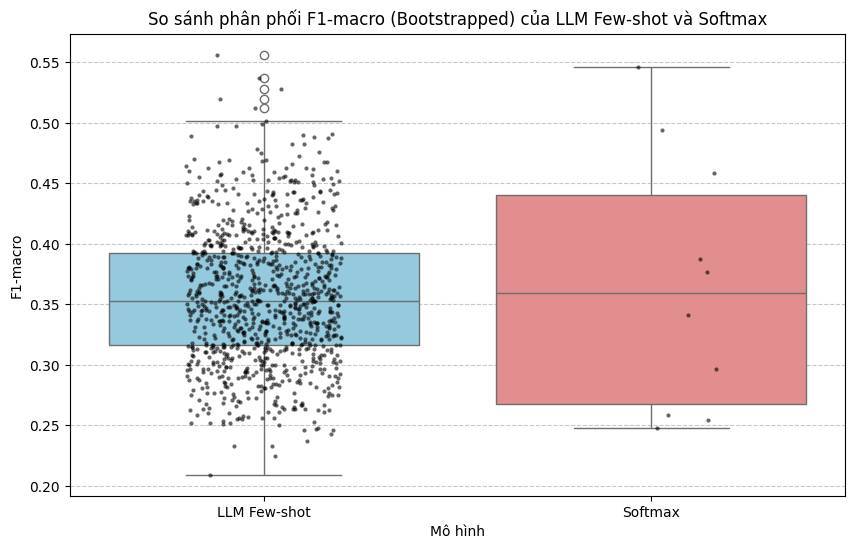

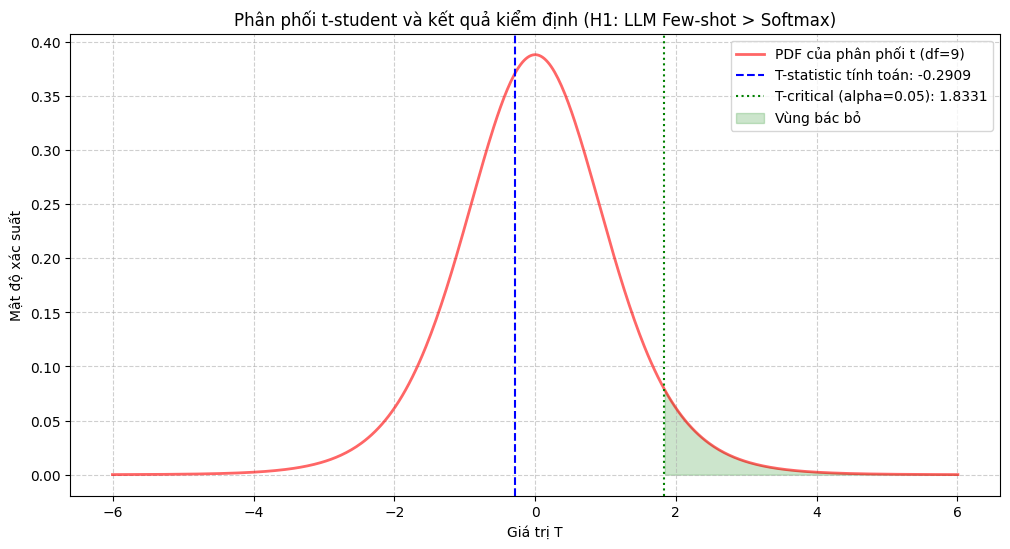

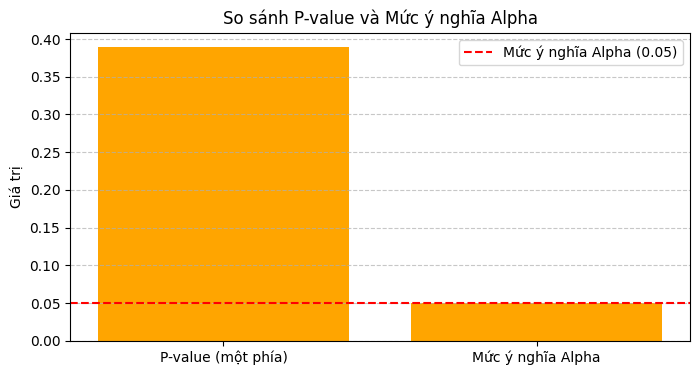


Kết quả T-test (LLM Few-shot vs Softmax):
  Thống kê T: -0.2909
  Giá trị P (một phía): 0.3889
  Kết luận: Không đủ bằng chứng để bác bỏ H0. Không có bằng chứng LLM Few-shot tốt hơn Softmax một cách có ý nghĩa thống kê (p=0.388851214).


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\2946448995.py:336: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mô hình', y='F1-macro', data=data_for_boxplot,


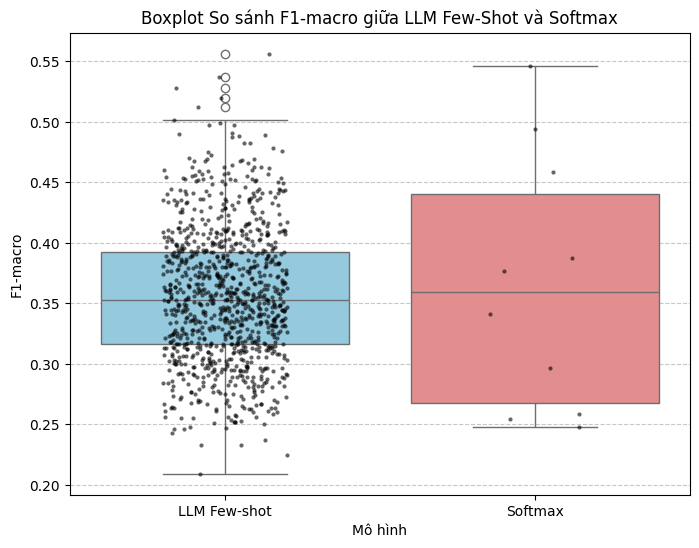

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, t # ttest_ind for independent samples
import pandas as pd 
import logging
import seaborn as sns
from sklearn.metrics import classification_report # Needed for F1-score calculation in bootstrapping
from typing import Optional, Dict, Any, List
import json
import re

# Cấu hình logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Các hàm hỗ trợ cần thiết cho việc lấy nhãn và tính toán ---

def extract_bloom_level(label_string: str) -> str:
    """
    Trích xuất cấp độ Bloom chính từ chuỗi nhãn có thể chứa mô tả.
    Ví dụ: "Remember (Ghi nhớ): Nhớ lại thông tin cơ bản..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    Tải dữ liệu đã gắn nhãn của người và máy, sau đó so sánh các nhãn Bloom.
    Hàm này được tối ưu để chỉ trả về true_labels và predicted_labels cho các kiểm định thống kê,
    không in ra các ma trận hay báo cáo chi tiết khác.

    Args:
        human_labeled_path (str): Đường dẫn đến file chứa dữ liệu do người gắn nhãn.
                                   Hỗ trợ CSV.
        llm_labeled_path (str): Đường dẫn đến file chứa dữ liệu do LLM gắn nhãn.
                                  Hỗ trợ CSV hoặc JSON.
        id_column (str): Tên cột chứa ID duy nhất của mỗi mục.
        human_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của người.
        llm_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của máy.

    Returns:
        Optional[Dict[str, Any]]: Một dictionary chứa true_labels và predicted_labels,
                                  hoặc None nếu có lỗi.
    """
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của người tại '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"Lỗi: File dữ liệu của người phải có cột '{id_column}' và '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của người '{human_labeled_path}': {e}", exc_info=True)
        return None

    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"Lỗi: Định dạng file dữ liệu của máy '{llm_labeled_path}' không được hỗ trợ. Chỉ chấp nhận .csv hoặc .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)

    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của máy tại '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"Lỗi: File dữ liệu của máy '{llm_labeled_path}' phải có cột '{id_column}' và '{llm_bloom_label_column}' và định dạng hợp lệ: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của máy '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"Mục '{item_id}': Nhãn Bloom rỗng hoặc không hợp lệ sau khi trích xuất. Bỏ qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"Mục '{item_id}' không có cột nhãn Bloom cần thiết ({e}). Bỏ qua.")
                continue
            except Exception as e:
                logger.warning(f"Lỗi xử lý mục '{item_id}': {e}. Bỏ qua.")
                continue

    if common_items_count == 0:
        logger.warning("Không tìm thấy mục chung nào giữa hai tập dữ liệu hoặc không có nhãn. Không thể tính các metric đồng thuận nhãn Bloom.")
        return None

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_bootstrapped_f1_scores(true_labels: List[str], predicted_labels: List[str], n_bootstraps: int = 10) -> List[float]:
    """
    Tạo ra phân phối F1-score bằng phương pháp bootstrapping.

    Args:
        true_labels (List[str]): Danh sách nhãn thực tế.
        predicted_labels (List[str]): Danh sách nhãn dự đoán.
        n_bootstraps (int): Số lần lấy mẫu lại.

    Returns:
        List[float]: Danh sách các F1-score tổng thể (macro avg) từ các mẫu lại.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh sách nhãn thực tế và dự đoán phải có cùng độ dài.")
    
    if not true_labels:
        return []

    f1_scores_distribution = []
    num_samples = len(true_labels)
    # Đảm bảo các nhãn khớp với các nhãn có thể có trong dữ liệu Bloom
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze'] 

    for _ in range(n_bootstraps):
        # Lấy mẫu lại các chỉ số với thay thế
        indices = np.random.choice(num_samples, num_samples, replace=True)
        
        # Tạo các mẫu lại của nhãn
        bootstrapped_true = [true_labels[i] for i in indices]
        bootstrapped_pred = [predicted_labels[i] for i in indices]
        
        # Tính F1-score cho mẫu lại
        # Sử dụng zero_division=0 để tránh lỗi khi một lớp không có mẫu nào trong mẫu lại
        report = classification_report(bootstrapped_true, bootstrapped_pred, 
                                       labels=bloom_categories, output_dict=True, zero_division=0)
        
        # Lấy F1-score tổng thể (macro avg)
        overall_f1 = report['macro avg']['f1-score'] # Lấy F1-macro
        f1_scores_distribution.append(overall_f1)
        
    return f1_scores_distribution

def perform_one_tailed_t_test(scores1: List[float], scores2: List[float], scores1_name: str, scores2_name: str, alpha: float = 0.05, hypothesis: str = "greater") -> Dict[str, Any]:
    """
    Thực hiện kiểm định T-test một phía cho hai mẫu độc lập và vẽ biểu đồ so sánh.

    Args:
        scores1 (List[float]): Danh sách điểm số cho nhóm thứ nhất.
        scores2 (List[float]): Danh sách điểm số cho nhóm thứ hai.
        scores1_name (str): Tên của nhóm thứ nhất (để hiển thị trên biểu đồ).
        scores2_name (str): Tên của nhóm thứ hai (để hiển thị trên biểu đồ).
        alpha (float): Mức ý nghĩa (significance level).
        hypothesis (str): "greater" nếu scores1 > scores2, "less" nếu scores1 < scores2.

    Returns:
        Dict[str, Any]: Dictionary chứa thống kê t, giá trị p, và kết luận.
    """
    if not scores1 or not scores2:
        logger.warning("Không đủ dữ liệu để thực hiện T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Không đủ dữ liệu."}
    
    if len(scores1) < 2 or len(scores2) < 2:
        logger.warning("Cần ít nhất 2 mẫu trong mỗi nhóm để thực hiện T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Không đủ mẫu để thực hiện T-test."}

    # Sử dụng ttest_ind vì đây là các mẫu độc lập (bootstrapped F1-scores)
    t_statistic, p_value_two_tailed = stats.ttest_ind(scores1, scores2, equal_var=False)

    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)

    conclusion = ""
    p_value_one_tailed = p_value_two_tailed / 2 # Luôn tính p-value một phía

    print(f"\nKiểm định T-test một phía (H1: {scores1_name} tốt hơn {scores2_name}):")
    print(f"  Giá trị trung bình F1-macro nhóm {scores1_name}: {mean1:.4f}")
    print(f"  Giá trị trung bình F1-macro nhóm {scores2_name}: {mean2:.4f}")
    print(f"  Thống kê T: {t_statistic:.4f}")
    print(f"  Giá trị P (hai phía): {p_value_two_tailed:.9f}") # In 9 chữ số sau dấu phẩy
    print(f"  Giá trị P (một phía): {p_value_one_tailed:.9f}") # In 9 chữ số sau dấu phẩy
    print(f"  Mức ý nghĩa alpha: {alpha}")

    if hypothesis == "greater":
        if t_statistic > 0 and p_value_one_tailed < alpha:
            conclusion = f"Bác bỏ H0. {scores1_name} tốt hơn {scores2_name} một cách có ý nghĩa thống kê (p={p_value_one_tailed:.9f})."
        else:
            conclusion = f"Không đủ bằng chứng để bác bỏ H0. Không có bằng chứng {scores1_name} tốt hơn {scores2_name} một cách có ý nghĩa thống kê (p={p_value_one_tailed:.9f})."
    else:
        conclusion = "Kiểm định không phù hợp với giả thuyết 'greater'."

    # --- Vẽ biểu đồ hộp so sánh phân phối điểm số ---
    plt.figure(figsize=(10, 6))
    data_to_plot = pd.DataFrame({
        'Mô hình': [scores1_name] * len(scores1) + [scores2_name] * len(scores2),
        'F1-macro': scores1 + scores2
    })
    sns.boxplot(x='Mô hình', y='F1-macro', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})
    sns.stripplot(x='Mô hình', y='F1-macro', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6) # Thêm các điểm dữ liệu
    plt.title(f'So sánh phân phối F1-macro (Bootstrapped) của {scores1_name} và {scores2_name}')
    plt.ylabel('F1-macro')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- Vẽ biểu đồ phân phối t-student và kết quả kiểm định ---
    plt.figure(figsize=(12, 6))

    df_approx = min(len(scores1), len(scores2)) - 1
    if df_approx < 1:
        df_approx = 1

    x = np.linspace(stats.t.ppf(0.0001, df_approx), stats.t.ppf(0.9999, df_approx), 500)
    plt.plot(x, stats.t.pdf(x, df_approx), 'r-', lw=2, alpha=0.6, label=f'PDF của phân phối t (df={df_approx})')

    plt.axvline(t_statistic, color='blue', linestyle='--', label=f'T-statistic tính toán: {t_statistic:.4f}')

    critical_value = stats.t.ppf(1 - alpha, df_approx) 
    plt.axvline(critical_value, color='green', linestyle=':', label=f'T-critical (alpha={alpha}): {critical_value:.4f}')

    x_rejection = x[x > critical_value]
    plt.fill_between(x_rejection, 0, stats.t.pdf(x_rejection, df_approx), color='green', alpha=0.2, label='Vùng bác bỏ')

    plt.title(f'Phân phối t-student và kết quả kiểm định (H1: {scores1_name} > {scores2_name})')
    plt.xlabel('Giá trị T')
    plt.ylabel('Mật độ xác suất')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- Vẽ biểu đồ so sánh P-value và Alpha ---
    plt.figure(figsize=(8, 4))
    bar_labels = ['P-value (một phía)', 'Mức ý nghĩa Alpha']
    bar_values = [p_value_one_tailed, alpha]
    colors = ['purple' if p_value_one_tailed < alpha else 'orange', 'orange']

    plt.bar(bar_labels, bar_values, color=colors)
    plt.axhline(alpha, color='red', linestyle='--', label=f'Mức ý nghĩa Alpha ({alpha})')
    plt.title('So sánh P-value và Mức ý nghĩa Alpha')
    plt.ylabel('Giá trị')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

    return {
        "t_statistic": t_statistic,
        "p_value_two_tailed": p_value_two_tailed,
        "p_value_one_tailed": p_value_one_tailed,
        "conclusion": conclusion
    }

# --- Cấu hình đường dẫn file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- Dữ liệu F1-macro của mô hình Softmax (từ 10 folds) ---
softmax_val_f1_macro = [0.5460, 0.2583, 0.4583, 0.3772, 0.2548,
                        0.4940, 0.2968, 0.3876, 0.2482, 0.3412] 

# --- Lấy nhãn từ file LLM Few-Shot và tạo phân phối F1-macro ---
logger.info("\n========== Lấy nhãn và tạo phân phối F1-macro cho LLM Few-Shot ==========")

bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

if bloom_labels_few_shot:
    f1_distribution_few_shot_macro = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels'],
        n_bootstraps=1000 # Đặt số lần bootstrap là 10
    )
    logger.info(f"Đã tạo {len(f1_distribution_few_shot_macro)} mẫu F1-macro cho LLM Few-shot bằng bootstrapping.")
else:
    logger.error("Không thể tạo phân phối F1-macro cho LLM Few-Shot. Không thể thực hiện kiểm định.")
    f1_distribution_few_shot_macro = [] # Đặt rỗng để tránh lỗi

# --- Thực hiện Kiểm định T-test so sánh LLM Few-Shot với Softmax ---
logger.info("\n========== Thực hiện Kiểm định T-test so sánh F1-macro của LLM Few-Shot và Softmax ==========")

if f1_distribution_few_shot_macro and softmax_val_f1_macro:
    t_test_results_softmax = perform_one_tailed_t_test(
        scores1=f1_distribution_few_shot_macro, # Nhóm 1: LLM Few-shot (F1-macro)
        scores2=softmax_val_f1_macro,           # Nhóm 2: Softmax (F1-macro)
        scores1_name="LLM Few-shot", 
        scores2_name="Softmax",  
        hypothesis="greater" # Giả thuyết: LLM Few-shot tốt hơn Softmax
    )
    print(f"\nKết quả T-test (LLM Few-shot vs Softmax):")
    print(f"  Thống kê T: {t_test_results_softmax['t_statistic']:.4f}")
    print(f"  Giá trị P (một phía): {t_test_results_softmax['p_value_one_tailed']:.4f}")
    print(f"  Kết luận: {t_test_results_softmax['conclusion']}")
else:
    logger.error("Không đủ dữ liệu từ LLM Few-Shot hoặc Softmax để thực hiện T-test.")

# --- Biểu đồ Boxplot tổng hợp (chỉ bao gồm Few-shot và Softmax) ---
if f1_distribution_few_shot_macro and softmax_val_f1_macro:
    plt.figure(figsize=(8, 6))
    
    data_for_boxplot = pd.DataFrame({
        'Mô hình': ['LLM Few-shot'] * len(f1_distribution_few_shot_macro) +
                   ['Softmax'] * len(softmax_val_f1_macro),
        'F1-macro': f1_distribution_few_shot_macro + softmax_val_f1_macro
    })

    sns.boxplot(x='Mô hình', y='F1-macro', data=data_for_boxplot, 
                palette={'LLM Few-shot': 'skyblue', 'Softmax': 'lightcoral'})
    sns.stripplot(x='Mô hình', y='F1-macro', data=data_for_boxplot, color='black', size=3, jitter=0.2, alpha=0.6)
    
    plt.title("Boxplot So sánh F1-macro giữa LLM Few-Shot và Softmax")
    plt.ylabel("F1-macro")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


2025-07-02 00:43:23,438 - INFO - 
========== Lấy nhãn để thực hiện T-test (F1-macro) ==========
2025-07-02 00:43:23,478 - INFO - 
========== Thực hiện Kiểm định T-test so sánh F1-macro của Few-Shot và No-Shot ==========
C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\3852478751.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mô hình', y='F1-macro', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})



Kiểm định T-test một phía (H1: Few-shot tốt hơn No-shot):
  Giá trị trung bình F1-macro nhóm Few-shot: 0.3870
  Giá trị trung bình F1-macro nhóm No-shot: 0.3101
  Thống kê T: 4.4225
  Giá trị P (hai phía): 0.000339668
  Giá trị P (một phía): 0.000169834
  Mức ý nghĩa alpha: 0.05


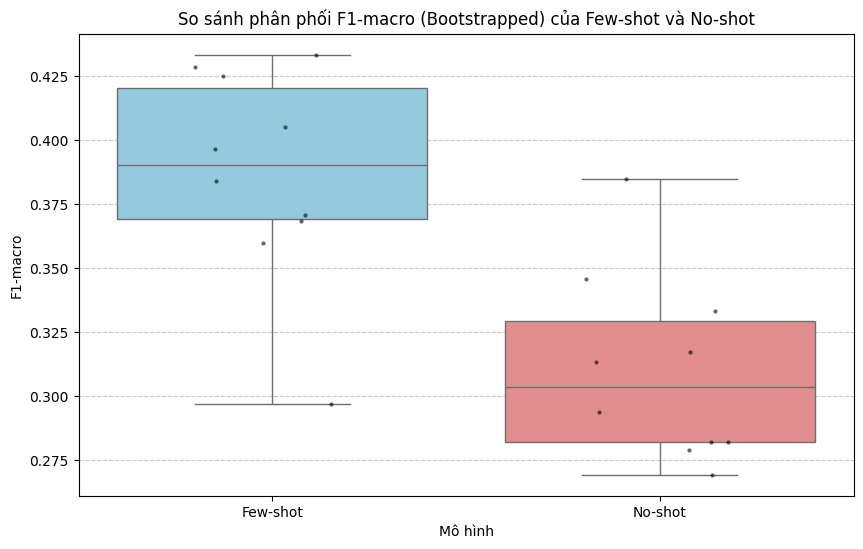

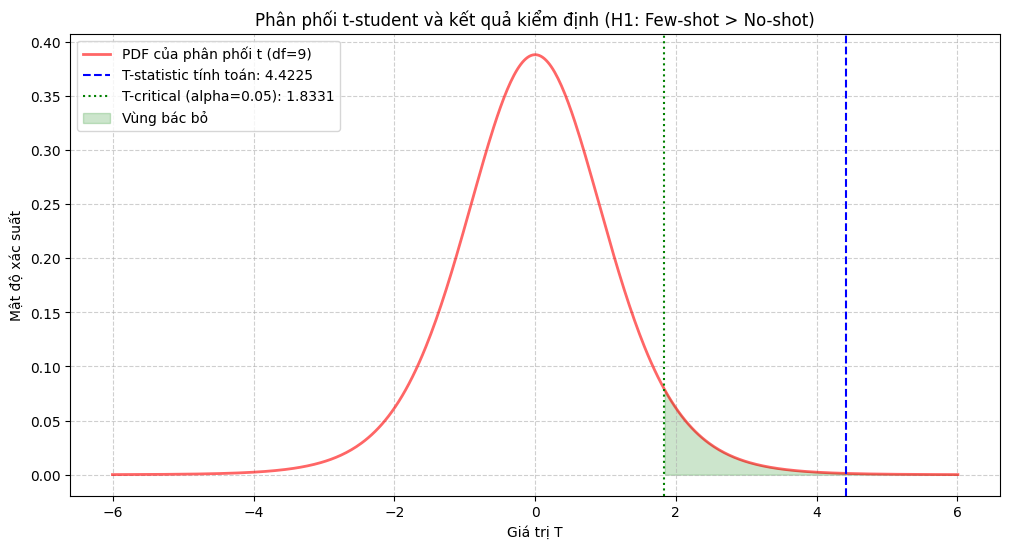

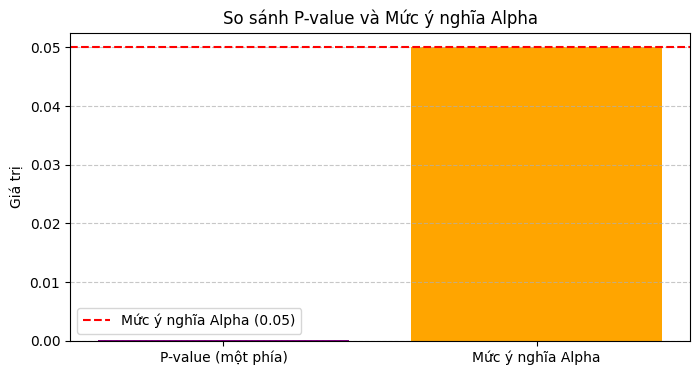


Kết quả T-test:
  Thống kê T: 4.4225
  Giá trị P (một phía): 0.0002
  Kết luận: Bác bỏ H0. Few-shot tốt hơn No-shot một cách có ý nghĩa thống kê (p=0.000169834).


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_23424\3852478751.py:361: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mô hình', y='F1-macro', data=data_for_boxplot,


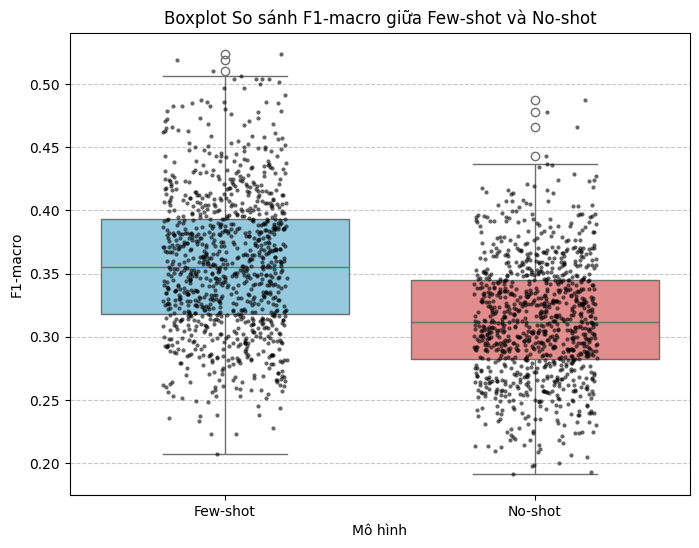

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, t # ttest_ind for independent samples
import pandas as pd 
import logging
import seaborn as sns
from sklearn.metrics import classification_report # Needed for F1-score calculation in bootstrapping
from typing import Optional, Dict, Any, List
import json
import re

# Cấu hình logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Các hàm hỗ trợ cần thiết cho việc lấy nhãn và tính toán ---

def extract_bloom_level(label_string: str) -> str:
    """
    Trích xuất cấp độ Bloom chính từ chuỗi nhãn có thể chứa mô tả.
    Ví dụ: "Remember (Ghi nhớ): Nhớ lại thông tin cơ bản..." -> "Remember"
    """
    if not isinstance(label_string, str):
        return str(label_string).strip()

    match = re.match(r'([A-Za-z]+)', label_string.strip())
    if match:
        return match.group(1)
    return label_string.strip()

def evaluate_bloom_labels_for_ttest(human_labeled_path: str, llm_labeled_path: str,
                                     id_column: str = 'question', 
                                     human_bloom_label_column: str = 'bloom',
                                     llm_bloom_label_column: str = 'bloom_label') -> Optional[Dict[str, Any]]:
    """
    Tải dữ liệu đã gắn nhãn của người và máy, sau đó so sánh các nhãn Bloom.
    Hàm này được tối ưu để chỉ trả về true_labels và predicted_labels cho các kiểm định thống kê,
    không in ra các ma trận hay báo cáo chi tiết khác.

    Args:
        human_labeled_path (str): Đường dẫn đến file chứa dữ liệu do người gắn nhãn.
                                   Hỗ trợ CSV.
        llm_labeled_path (str): Đường dẫn đến file chứa dữ liệu do LLM gắn nhãn.
                                  Hỗ trợ CSV hoặc JSON.
        id_column (str): Tên cột chứa ID duy nhất của mỗi mục.
        human_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của người.
        llm_bloom_label_column (str): Tên cột chứa nhãn Bloom trong file của máy.

    Returns:
        Optional[Dict[str, Any]]: Một dictionary chứa true_labels và predicted_labels,
                                  hoặc None nếu có lỗi.
    """
    try:
        human_df = pd.read_csv(human_labeled_path, encoding='utf-8')
        human_df_indexed = human_df.set_index(id_column)
    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của người tại '{human_labeled_path}'.")
        return None
    except KeyError:
        logger.error(f"Lỗi: File dữ liệu của người phải có cột '{id_column}' và '{human_bloom_label_column}'.")
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của người '{human_labeled_path}': {e}", exc_info=True)
        return None

    try:
        if llm_labeled_path.lower().endswith('.csv'):
            pred_df = pd.read_csv(llm_labeled_path, encoding='utf-8')
        elif llm_labeled_path.lower().endswith('.json'):
            with open(llm_labeled_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            pred_df = pd.DataFrame(data)
        else:
            logger.error(f"Lỗi: Định dạng file dữ liệu của máy '{llm_labeled_path}' không được hỗ trợ. Chỉ chấp nhận .csv hoặc .json.")
            return None
            
        llm_df_indexed = pred_df.set_index(id_column)

    except FileNotFoundError:
        logger.error(f"Lỗi: Không tìm thấy file dữ liệu của máy tại '{llm_labeled_path}'.")
        return None
    except (KeyError, ValueError) as e:
        logger.error(f"Lỗi: File dữ liệu của máy '{llm_labeled_path}' phải có cột '{id_column}' và '{llm_bloom_label_column}' và định dạng hợp lệ: {e}", exc_info=True)
        return None
    except Exception as e:
        logger.error(f"Lỗi khi tải file dữ liệu của máy '{llm_labeled_path}': {e}", exc_info=True)
        return None

    true_labels = []
    predicted_labels = []
    common_items_count = 0

    for item_id in human_df_indexed.index:
        if item_id in llm_df_indexed.index:
            try:
                human_label_raw = str(human_df_indexed.loc[item_id][human_bloom_label_column])
                human_label = extract_bloom_level(human_label_raw)

                llm_label_raw = str(llm_df_indexed.loc[item_id][llm_bloom_label_column])
                llm_label = extract_bloom_level(llm_label_raw)

                if not human_label or not llm_label:
                    logger.warning(f"Mục '{item_id}': Nhãn Bloom rỗng hoặc không hợp lệ sau khi trích xuất. Bỏ qua.")
                    continue

                true_labels.append(human_label)
                predicted_labels.append(llm_label)
                common_items_count += 1
            except KeyError as e:
                logger.warning(f"Mục '{item_id}' không có cột nhãn Bloom cần thiết ({e}). Bỏ qua.")
                continue
            except Exception as e:
                logger.warning(f"Lỗi xử lý mục '{item_id}': {e}. Bỏ qua.")
                continue

    if common_items_count == 0:
        logger.warning("Không tìm thấy mục chung nào giữa hai tập dữ liệu hoặc không có nhãn. Không thể tính các metric đồng thuận nhãn Bloom.")
        return None

    return {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels
    }

def get_bootstrapped_f1_scores(true_labels: List[str], predicted_labels: List[str], n_bootstraps: int = 10) -> List[float]:
    """
    Tạo ra phân phối F1-score bằng phương pháp bootstrapping.

    Args:
        true_labels (List[str]): Danh sách nhãn thực tế.
        predicted_labels (List[str]): Danh sách nhãn dự đoán.
        n_bootstraps (int): Số lần lấy mẫu lại.

    Returns:
        List[float]: Danh sách các F1-score tổng thể (macro avg) từ các mẫu lại.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Danh sách nhãn thực tế và dự đoán phải có cùng độ dài.")
    
    if not true_labels:
        return []

    f1_scores_distribution = []
    num_samples = len(true_labels)
    # Đảm bảo các nhãn khớp với các nhãn có thể có trong dữ liệu Bloom
    bloom_categories = ['Remember', 'Understand', 'Apply', 'Analyze'] 

    for _ in range(n_bootstraps):
        # Lấy mẫu lại các chỉ số với thay thế
        indices = np.random.choice(num_samples, num_samples, replace=True)
        
        # Tạo các mẫu lại của nhãn
        bootstrapped_true = [true_labels[i] for i in indices]
        bootstrapped_pred = [predicted_labels[i] for i in indices]
        
        # Tính F1-score cho mẫu lại
        # Sử dụng zero_division=0 để tránh lỗi khi một lớp không có mẫu nào trong mẫu lại
        report = classification_report(bootstrapped_true, bootstrapped_pred, 
                                       labels=bloom_categories, output_dict=True, zero_division=0)
        
        # Lấy F1-score tổng thể (macro avg)
        overall_f1 = report['macro avg']['f1-score'] # Lấy F1-macro
        f1_scores_distribution.append(overall_f1)
        
    return f1_scores_distribution

def perform_one_tailed_t_test(scores1: List[float], scores2: List[float], scores1_name: str, scores2_name: str, alpha: float = 0.05, hypothesis: str = "greater") -> Dict[str, Any]:
    """
    Thực hiện kiểm định T-test một phía cho hai mẫu độc lập và vẽ biểu đồ so sánh.

    Args:
        scores1 (List[float]): Danh sách điểm số cho nhóm thứ nhất.
        scores2 (List[float]): Danh sách điểm số cho nhóm thứ hai.
        scores1_name (str): Tên của nhóm thứ nhất (để hiển thị trên biểu đồ).
        scores2_name (str): Tên của nhóm thứ hai (để hiển thị trên biểu đồ).
        alpha (float): Mức ý nghĩa (significance level).
        hypothesis (str): "greater" nếu scores1 > scores2, "less" nếu scores1 < scores2.

    Returns:
        Dict[str, Any]: Dictionary chứa thống kê t, giá trị p, và kết luận.
    """
    if not scores1 or not scores2:
        logger.warning("Không đủ dữ liệu để thực hiện T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Không đủ dữ liệu."}
    
    if len(scores1) < 2 or len(scores2) < 2:
        logger.warning("Cần ít nhất 2 mẫu trong mỗi nhóm để thực hiện T-test.")
        return {"t_statistic": None, "p_value": None, "conclusion": "Không đủ mẫu để thực hiện T-test."}

    # Sử dụng ttest_ind vì đây là các mẫu độc lập (bootstrapped F1-scores)
    t_statistic, p_value_two_tailed = stats.ttest_ind(scores1, scores2, equal_var=False)

    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)

    conclusion = ""
    p_value_one_tailed = p_value_two_tailed / 2 # Luôn tính p-value một phía

    print(f"\nKiểm định T-test một phía (H1: {scores1_name} tốt hơn {scores2_name}):")
    print(f"  Giá trị trung bình F1-macro nhóm {scores1_name}: {mean1:.4f}")
    print(f"  Giá trị trung bình F1-macro nhóm {scores2_name}: {mean2:.4f}")
    print(f"  Thống kê T: {t_statistic:.4f}")
    print(f"  Giá trị P (hai phía): {p_value_two_tailed:.9f}") # In 9 chữ số sau dấu phẩy
    print(f"  Giá trị P (một phía): {p_value_one_tailed:.9f}") # In 9 chữ số sau dấu phẩy
    print(f"  Mức ý nghĩa alpha: {alpha}")

    if hypothesis == "greater":
        if t_statistic > 0 and p_value_one_tailed < alpha:
            conclusion = f"Bác bỏ H0. {scores1_name} tốt hơn {scores2_name} một cách có ý nghĩa thống kê (p={p_value_one_tailed:.9f})."
        else:
            conclusion = f"Không đủ bằng chứng để bác bỏ H0. Không có bằng chứng {scores1_name} tốt hơn {scores2_name} một cách có ý nghĩa thống kê (p={p_value_one_tailed:.9f})."
    else:
        conclusion = "Kiểm định không phù hợp với giả thuyết 'greater'."

    # --- Vẽ biểu đồ hộp so sánh phân phối điểm số ---
    plt.figure(figsize=(10, 6))
    data_to_plot = pd.DataFrame({
        'Mô hình': [scores1_name] * len(scores1) + [scores2_name] * len(scores2),
        'F1-macro': scores1 + scores2
    })
    sns.boxplot(x='Mô hình', y='F1-macro', data=data_to_plot, palette={scores1_name: 'skyblue', scores2_name: 'lightcoral'})
    sns.stripplot(x='Mô hình', y='F1-macro', data=data_to_plot, color='black', size=3, jitter=0.2, alpha=0.6) # Thêm các điểm dữ liệu
    plt.title(f'So sánh phân phối F1-macro (Bootstrapped) của {scores1_name} và {scores2_name}')
    plt.ylabel('F1-macro')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- Vẽ biểu đồ phân phối t-student và kết quả kiểm định ---
    plt.figure(figsize=(12, 6))

    df_approx = min(len(scores1), len(scores2)) - 1
    if df_approx < 1:
        df_approx = 1

    x = np.linspace(stats.t.ppf(0.0001, df_approx), stats.t.ppf(0.9999, df_approx), 500)
    plt.plot(x, stats.t.pdf(x, df_approx), 'r-', lw=2, alpha=0.6, label=f'PDF của phân phối t (df={df_approx})')

    plt.axvline(t_statistic, color='blue', linestyle='--', label=f'T-statistic tính toán: {t_statistic:.4f}')

    critical_value = stats.t.ppf(1 - alpha, df_approx) 
    plt.axvline(critical_value, color='green', linestyle=':', label=f'T-critical (alpha={alpha}): {critical_value:.4f}')

    x_rejection = x[x > critical_value]
    plt.fill_between(x_rejection, 0, stats.t.pdf(x_rejection, df_approx), color='green', alpha=0.2, label='Vùng bác bỏ')

    plt.title(f'Phân phối t-student và kết quả kiểm định (H1: {scores1_name} > {scores2_name})')
    plt.xlabel('Giá trị T')
    plt.ylabel('Mật độ xác suất')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- Vẽ biểu đồ so sánh P-value và Alpha ---
    plt.figure(figsize=(8, 4))
    bar_labels = ['P-value (một phía)', 'Mức ý nghĩa Alpha']
    bar_values = [p_value_one_tailed, alpha]
    colors = ['purple' if p_value_one_tailed < alpha else 'orange', 'orange']

    plt.bar(bar_labels, bar_values, color=colors)
    plt.axhline(alpha, color='red', linestyle='--', label=f'Mức ý nghĩa Alpha ({alpha})')
    plt.title('So sánh P-value và Mức ý nghĩa Alpha')
    plt.ylabel('Giá trị')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

    return {
        "t_statistic": t_statistic,
        "p_value_two_tailed": p_value_two_tailed,
        "p_value_one_tailed": p_value_one_tailed,
        "conclusion": conclusion
    }

# --- Cấu hình đường dẫn file ---
human_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\Test_102_labeled_human.csv" 
no_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_no_test102.json"
few_shot_llm_bloom_path = r"D:\vscodepython\DOAN\uit.PubHealthQA\data\gold\DS102_data\labeled_output_LLMs_few_test102.json" 

ITEM_ID_COLUMN = 'question'
HUMAN_BLOOM_LABEL_COLUMN = 'bloom'
LLM_BLOOM_LABEL_COLUMN = 'bloom_label'

# --- Lấy nhãn từ các file few-shot và no-shot ---
logger.info("\n========== Lấy nhãn để thực hiện T-test (F1-macro) ==========")

# Lấy nhãn cho No-Shot
bloom_labels_no_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=no_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# Lấy nhãn cho Few-Shot
bloom_labels_few_shot = evaluate_bloom_labels_for_ttest(
    human_labeled_path=human_bloom_path,
    llm_labeled_path=few_shot_llm_bloom_path,
    id_column=ITEM_ID_COLUMN,
    human_bloom_label_column=HUMAN_BLOOM_LABEL_COLUMN,
    llm_bloom_label_column=LLM_BLOOM_LABEL_COLUMN
)

# --- Thực hiện T-test so sánh Few-Shot và No-Shot ---
logger.info("\n========== Thực hiện Kiểm định T-test so sánh F1-macro của Few-Shot và No-Shot ==========")

if bloom_labels_no_shot and bloom_labels_few_shot:
    # Tạo phân phối F1-macro bằng bootstrapping
    f1_scores_distribution_no_shot_macro = get_bootstrapped_f1_scores(
        bloom_labels_no_shot['true_labels'],
        bloom_labels_no_shot['predicted_labels'],
        n_bootstraps=10 # Đặt số lần bootstrap là 10
    )
    f1_scores_distribution_few_shot_macro = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels'],
        n_bootstraps=10 # Đặt số lần bootstrap là 10
    )

    # Đảm bảo có đủ dữ liệu từ bootstrapping
    if not f1_scores_distribution_no_shot_macro or not f1_scores_distribution_few_shot_macro:
        logger.error("Không đủ dữ liệu F1-macro từ bootstrapping để thực hiện T-test.")
    else:
        # Thực hiện T-test một phía (H1: few-shot tốt hơn no-shot)
        t_test_results = perform_one_tailed_t_test(
            scores1=f1_scores_distribution_few_shot_macro, # Nhóm 1: Few-shot
            scores2=f1_scores_distribution_no_shot_macro,  # Nhóm 2: No-shot
            scores1_name="Few-shot", # Tên cho biểu đồ
            scores2_name="No-shot",  # Tên cho biểu đồ
            hypothesis="greater" # Giả thuyết: Few-shot tốt hơn No-shot
        )
        print(f"\nKết quả T-test:")
        print(f"  Thống kê T: {t_test_results['t_statistic']:.4f}")
        print(f"  Giá trị P (một phía): {t_test_results['p_value_one_tailed']:.4f}")
        print(f"  Kết luận: {t_test_results['conclusion']}")
else:
    logger.error("Không đủ kết quả đánh giá nhãn Bloom từ cả hai mô hình để thực hiện T-test.")

# --- Biểu đồ Boxplot tổng hợp (chỉ bao gồm Few-shot và No-shot) ---
if bloom_labels_no_shot and bloom_labels_few_shot:
    f1_scores_distribution_no_shot_macro = get_bootstrapped_f1_scores(
        bloom_labels_no_shot['true_labels'],
        bloom_labels_no_shot['predicted_labels'],
        n_bootstraps=1000
    )
    f1_scores_distribution_few_shot_macro = get_bootstrapped_f1_scores(
        bloom_labels_few_shot['true_labels'],
        bloom_labels_few_shot['predicted_labels'],
        n_bootstraps=1000
    )

    if f1_scores_distribution_few_shot_macro and f1_scores_distribution_no_shot_macro:
        plt.figure(figsize=(8, 6))
        
        data_for_boxplot = pd.DataFrame({
            'Mô hình': ['Few-shot'] * len(f1_scores_distribution_few_shot_macro) +
                       ['No-shot'] * len(f1_scores_distribution_no_shot_macro),
            'F1-macro': f1_scores_distribution_few_shot_macro + f1_scores_distribution_no_shot_macro
        })

        sns.boxplot(x='Mô hình', y='F1-macro', data=data_for_boxplot, 
                    palette={'Few-shot': 'skyblue', 'No-shot': 'lightcoral'})
        sns.stripplot(x='Mô hình', y='F1-macro', data=data_for_boxplot, color='black', size=3, jitter=0.2, alpha=0.6)
        
        plt.title("Boxplot So sánh F1-macro giữa Few-shot và No-shot")
        plt.ylabel("F1-macro")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        logger.error("Không đủ dữ liệu F1-macro để vẽ Boxplot tổng hợp.")
